# Transformer Signal Generation 9
### Prompt Tuning

In [1]:
import torch
import torch.nn as nn
import os
import math
import h5py
import pickle
import numpy as np
import matplotlib.pyplot as plt
import random
from torch.utils.data import Dataset, DataLoader, random_split

# Set Model Save Parameters
model_save_folder = "Baseline" # Model Save Folder Path
model_save_name = "baseline" # Model Name

# Create Save Directories
os.makedirs(model_save_folder, exist_ok=True) # Check if the Model directory exists, if not, create it
model_save_path = os.path.join(model_save_folder, model_save_name)
folder_path = f"{model_save_path}_figures" # Figuers folder save path
os.makedirs(folder_path, exist_ok=True) # Check if the Figures directory exists, if not, create it
loss_save_path = f"{model_save_path}_loss_data.pkl"

# Printout
print(f"Model Save Directory: {model_save_path}")
print(f"Loss Data Directory: {loss_save_path}")

Model Save Directory: Baseline\baseline
Loss Data Directory: Baseline\baseline_loss_data.pkl


## Model

In [2]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=1000):
        super(PositionalEncoding, self).__init__()
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :, :]
        return x

class TimeSeriesTransformer(nn.Module):
    def __init__(self, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward):
        super(TimeSeriesTransformer, self).__init__()
        
        self.embedding = nn.Linear(1, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_encoder_layers)

        # Decoder for force
        self.decoder_layer_force = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward)
        self.transformer_decoder_force = nn.TransformerDecoder(self.decoder_layer_force, num_layers=num_decoder_layers)
        self.output_force = nn.Linear(d_model, 1) # Assuming output dimension is same as d_model

        # the decoder for disp
        self.decoder_layer_disp = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward)
        self.transformer_decoder_disp = nn.TransformerDecoder(self.decoder_layer_disp, num_layers=num_decoder_layers)
        self.output_disp = nn.Linear(d_model, 1)

    def forward(self, seq1, padding_mask, metadata=None):
        # Preparing
        seq1 = torch.permute(seq1, (1, 0, 2))  # reshape (B, L, D) -> (L, B, D)
        src = self.embedding(seq1) # embed the input sequece
        #print("DR Curve Embedded Dimensions: ", src.shape)
        encoder_input = self.pos_encoder(src)
        memory = self.transformer_encoder(encoder_input, src_key_padding_mask=padding_mask)
        
        # Force and displacement decoders
        output_force = self.transformer_decoder_force(memory, memory, tgt_key_padding_mask=padding_mask)
        output_force = self.output_force(output_force)
        output_force = output_force.permute(1,0,2) # change the shape back to (B, L, D)
       
        output_disp = self.transformer_decoder_disp(memory, memory, tgt_key_padding_mask=padding_mask)
        output_disp = self.output_disp(output_disp)
        output_disp = output_disp.permute(1,0,2)

        return output_force, output_disp

## Functions

In [3]:
#Functions

# Custom dataset class
class TimeSeriesDataset(Dataset):
    def __init__(self, input_data, target_force, target_disp, mask_list, metadata, plotting_data):
        # Convert lists of numpy arrays to single numpy arrays
        input_data_np = np.array(input_data)
        target_force_np = np.array(target_force)
        target_disp_np = np.array(target_disp)
        mask_list_np = np.array(mask_list)
        metadata_np = np.array(metadata)

        # Convert NumPy arrays to PyTorch tensors
        self.input_data = torch.from_numpy(input_data_np).float()
        self.target_force = torch.from_numpy(target_force_np).float()
        self.target_disp = torch.from_numpy(target_disp_np).float()
        self.mask_list = torch.from_numpy(mask_list_np).float()
        self.metadata = torch.from_numpy(metadata_np).float()
        self.plotting_data = plotting_data
        
    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, idx):
        return (
            self.input_data[idx],       # 0
            self.target_force[idx],     # 1
            self.target_disp[idx],      # 2
            self.mask_list[idx],        # 3
            self.metadata[idx],         # 4
            self.plotting_data[idx]     # 5
        )

# Set random seed for everything at once
def seed_everything(seed = 13):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Normalize sequence to have mean = 0 and std = 1
def normalize_columns(matrix):
    # Compute the mean and standard deviation for each column
    col_means = matrix.mean(axis=0)
    col_stds = matrix.std(axis=0)
    if np.any(col_stds==0):
        print("ERROR: Standard Deviation is 0. Check that all series vary in value")
    normalized_series = (matrix - col_means) / col_stds
    return normalized_series, [col_means, col_stds]

def normalize_all_columns(ts_data):
    normalized_ts_data, original_mean_std = [], [] # Initialize
    for sequence in ts_data:
        norm_seq, mean_std = normalize_columns(sequence[:, 0:5])  # normalize the first 5 columns
        normalized_ts_data.append(norm_seq)
        original_mean_std.append(mean_std)
    return normalized_ts_data, original_mean_std
    

def denormalize(normalized_sequence, original_mean, original_std):
    denormalized_sequence = (normalized_sequence * original_std) + original_mean
    return denormalized_sequence

# Add padding to max length
def pad_data(ts_data):
    padded_series_list, ppl_list, mask_list = [], [], []  # Initialize lists to hold the padded time series, original lengths, and padding masks
    max_length = max(len(series) for series in ts_data)  # Find the length of the longest time series

    for series in ts_data:
        padding_length = max_length - len(series)  # Calculate the number of rows to pad
        padding = np.zeros((padding_length, series.shape[1]))  # Create the padding rows
        padded_series = np.vstack((series, padding))  # Append the padding to the end of the series
        padded_series_list.append(padded_series)  # Add the padded series to the new list
        ppl_list.append(len(series))  # Record the original series length to remove padding later

        # Create the padding mask for the current series
        mask = [False] * len(series) + [True] * padding_length  # False where original data is, True where padding is added
        mask_list.append(mask)  # Add the padding mask to the mask list
    print("Padded to", max_length)

    return padded_series_list, ppl_list, mask_list

# Takes in unpadded sequences and returns mask
def create_mask(sequences, max_length):
        padding_mask = np.zeros((len(sequences), max_length), dtype=bool) 
        for i, sequence in enumerate(sequences):
             padding_mask[i, len(sequence):] = True
        return padding_mask

# Define Loss Function
def loss_function(pred_force, target_batch_force, pred_disp, target_batch_disp):
    mse_loss_force = nn.MSELoss()(pred_force, target_batch_force)
    mse_loss_disp = nn.MSELoss()(pred_disp, target_batch_disp)
    l1_loss_force = nn.L1Loss()(pred_force, target_batch_force)
    l1_loss_disp = nn.L1Loss()(pred_disp, target_batch_disp)
    return (mse_loss_force + mse_loss_disp) + 0.15 * (l1_loss_force + l1_loss_disp)

# Combined RMSE function
def combined_rmse(target_force, pred_force, target_disp, pred_disp):
    # Concatenate all targets and predictions
    Y_combined = np.concatenate((target_force, target_disp))
    Ypre_combined = np.concatenate((pred_force, pred_disp))
    # Calculate and return RMSE
    return np.sqrt(np.mean((Y_combined - Ypre_combined) ** 2))

# Combined R Squared function
def combined_r2(target_force, pred_force, target_disp, pred_disp):
    # Concatenate all targets and predictions
    Y_combined = np.concatenate((target_force, target_disp))
    Ypre_combined = np.concatenate((pred_force, pred_disp))
    # Calculate SSR and SST for combined data
    ssr = np.sum((Y_combined - Ypre_combined) ** 2)
    sst = np.sum((Y_combined - np.mean(Y_combined)) ** 2)
    # Calculate and return R^2
    return 1 - (ssr / sst)


def plot_function(results, save_path):
    # Set the default font to Times New Roman for all text in the plots
    from matplotlib import rcParams
    rcParams['font.family'] = 'serif'
    rcParams['font.serif'] = ['Times New Roman']

    # Plot the predicted and input curves
    for index, result in enumerate(results):
        # Set up the subplot grid
        fig, (ax3, ax1, ax2) = plt.subplots(1, 3, figsize=(24, 6))  # 1 row, 3 columns, switched order of axes

        # Plotting resistance on the first plot (far left)
        color = 'tab:red'
        ax3.set_xlabel('Time Steps')
        ax3.set_ylabel('Resistance', color=color)
        ax3.plot(result[5], label='Dynamic Resistance', color=color)
        ax3.tick_params(axis='y', labelcolor=color)
        ax3.legend(loc='lower right')
        ax3.set_title(f'Weld #{index+1} ({result[0]}) Resistance')

        # Plotting the force on the second plot (middle)
        color = 'tab:blue'
        ax1.set_xlabel('Time Steps')
        ax1.set_ylabel('Force', color=color)
        ax1.plot(result[1], label='True Force', color='black', linestyle=':')
        ax1.plot(result[2], label='Predicted Force', color=color)
        ax1.tick_params(axis='y', labelcolor=color)
        ax1.legend(loc='lower right')
        ax1.set_title(f'Weld #{index+1} ({result[0]}) Force')

        # Plotting the displacement on the third plot (far right)
        color = 'tab:green'
        ax2.set_xlabel('Time Steps')
        ax2.set_ylabel('Displacement', color=color)
        ax2.plot(result[3], label='True Displacement', color='black', linestyle=':')
        ax2.plot(result[4], label='Predicted Displacement', color=color)
        ax2.tick_params(axis='y', labelcolor=color)
        ax2.legend(loc='lower right')
        ax2.set_title(f'Weld #{index+1} ({result[0]}) Displacement')

        # Adjust layout to not overlap
        plt.tight_layout()

        # Save the figure into the specified folder
        plt.savefig(f'{save_path}/Weld_{index+1}_{result[0]}.png')
        plt.show()

def plot_loss(loss_pickel, save_path):
    # Load the loss data from the pickle file
    with open(loss_pickel, 'rb') as file:
        train_loss_plot = pickle.load(file)
    # Plot the loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss_plot, label='Training Loss')
    plt.title('Loss vs Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.savefig(f'{save_path}/Loss vs Epoch') # Save the figure into the Figures folder
    plt.show()

## Data Loader

In [4]:
# Open the HDF5 file in read mode
data_path = r'C:\Users\eyo232\OneDrive - University of Kentucky\3 - GM Spot Weld\1 - Data\HDF5 Databases\DOE 1 v3 [Modified].h5'
file = h5py.File(data_path, 'r')

# Print out the attributes (Metadata)
first_key = list(file.keys())[0] # get the key (name) of the first weld
print("Included Attributes:")
for key, value in file[first_key].attrs.items():
    print(f"\t{key}: {value}")


ts_data, weld_names, stackup_IDs, set_currents, set_forces = [], [], [], [], [] # 3d array (array of 2d matrices)
for weld_name in file:
    ts_data.append(file[weld_name][:]) # add whole time series matrix to the ts_data array
    weld_names.append(weld_name)
    stackup_IDs.append(file[weld_name].attrs['CustomStackup'])
    set_currents.append(file[weld_name].attrs['Current_S1 (kA)'])
    set_forces.append(file[weld_name].attrs['Force_S1'])

# save headers and stackupIDs as variables
headers = file[first_key].attrs['headers']
unique_stackup_IDs = list(set(stackup_IDs))

print(f"\nSuccessfully imported {len(ts_data)} data points")
print(f"Time Series Features: {ts_data[0].shape[1]}")
print(f"Stackup IDs: {unique_stackup_IDs}")


Included Attributes:
	Bi-CurrentType: Single
	Bi-PartID: 1059201
	Bi-UniqueSampleNo: StSt075_220531-I030-WL-7-1-1
	Coating #1: AS-4IDL
	Coating #2: AS-4IDL
	Current_S1 (kA): 7.0
	CustomStackup: 1
	Force_S1: 2.6
	Grade #1: PHS-1500
	Grade #2: PHS-1500
	Stackup#: StSt075
	Supplier #1: CC
	Supplier #2: CC
	Thickness #1 (mm): 1.0
	Thickness #2 (mm): 1.0
	extended_notes: 2.6kN,585lbs,StSt075,170ms@7kA,HT=40ms,Size_2_Caps
	headers: ['resistance_data' 'force' 'Bi-Disp-GunStiff' 'current_data' 'Bi-Msec'
 'Schedule']
	vspotid: StSt075-I030-WL-7

Successfully imported 708 data points
Time Series Features: 6
Stackup IDs: [1, 2, 3]


## Data Preparation

In [5]:
disp_index, force_index, input_index = 0,1,2 # assign english names to the indexes for readability

# Normalize and Pad Data
normalized_ts_data, original_mean_std = normalize_all_columns(ts_data)
padded_series_list, ppl_list, mask_list = pad_data(normalized_ts_data)

# Prepare attributes and plotting data
metadata, plotting_data = [], []
for i in range(len(ts_data)): # for each sequence loaded...
    metadata.append([stackup_IDs[i], set_currents[i], set_forces[i]])

    input_mean, input_std = original_mean_std[i][0][input_index], original_mean_std[i][1][input_index]
    force_mean, force_std = original_mean_std[i][0][force_index], original_mean_std[i][1][force_index]
    disp_mean, disp_std = original_mean_std[i][0][disp_index], original_mean_std[i][1][disp_index]
    
    plotting_data.append([weld_names[i], ppl_list[i], input_mean, input_std, force_mean, force_std, disp_mean, disp_std])


# Extract resistance_data (input), force and Bi-Disp-GunStiff (target) from ts_data
padded_ts_data = np.array(padded_series_list) # convert padded data to numpy array
input_data =   padded_ts_data[:,:,input_index][:, :, None]
target_force = padded_ts_data[:,:,force_index][:, :, None]
target_disp =  padded_ts_data[:,:,disp_index][:, :, None]
metadata = np.array(metadata) # convert to numpy array

# Set Random Seed
seed_everything(42)

# Create lists of data and unique stackup IDs
ts_dataset = TimeSeriesDataset(input_data, target_force, target_disp, mask_list, metadata, plotting_data)

# Split the stackup ids
stackup_set_1 = [2, 3]
stackup_set_2 = [1]

# Collect indices for each set based on stackupID (item[4][0]), with weld count limit
dataset1, dataset2 = [], []  # Lists to collect indices
for weld in ts_dataset:
    stackup_id = weld[4][0].item()  # Get the stackup ID from the item
    if stackup_id in stackup_set_1:
        dataset1.append(weld)  # Add to dataset1
    elif stackup_id in stackup_set_2:
        dataset2.append(weld)  # Add to dataset2

'''
# Random Split and batch
split_ratio = 0.8 # percent of dataset2 used for retraining
lengths = [int(len(dataset2) * split_ratio), len(dataset2) - int(len(dataset2) * split_ratio)] # Define the lengths of the splits
torch.manual_seed(42) # set random seed for consistency
dataset2_train, dataset2_test = random_split(dataset2, lengths) # Perform the random split
dataset1_batched = DataLoader(dataset1, batch_size=32, shuffle=True)
'''

# Standard Split and batch
split_index = int(len(dataset2) * 0.2) # set percet of data used for testing
dataset2_train = dataset2[split_index:]
dataset2_test = dataset2[:split_index]
dataset1_batched = DataLoader(dataset1, batch_size=32, shuffle=True)


#for weld in dataset2_test:
 #   print(f"Weld #: {weld[5][0]}")

# Print shapes
print(f"Dataset 1 (Train): \tStackups: {len(stackup_set_1)} \tWelds: {len(dataset1)} \tBatches = {len(dataset1_batched)}")
print(f"Dataset 2 (Train): \tStackups: {len(stackup_set_2)} \tWelds: {len(dataset2_train)}")
print(f"Dataset 2 (Test): \tStackups: {len(stackup_set_2)} \tWelds: {len(dataset2_test)}")

Padded to 240
Dataset 1 (Train): 	Stackups: 2 	Welds: 465 	Batches = 15
Dataset 2 (Train): 	Stackups: 1 	Welds: 195
Dataset 2 (Test): 	Stackups: 1 	Welds: 48


## Training

In [6]:
# Parameters
d_model = 256
nhead = 4
num_encoder_layers = 4
num_decoder_layers = 4
dim_feedforward = 1024
learning_rate = 0.0001
num_epochs = 600

# Define Model
model = TimeSeriesTransformer(d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # set device to GPU or CPU
print("Using device:", torch.cuda.get_device_name(0)) if torch.cuda.is_available() else print("Using CPU")
model.to(device) # send model to selected device
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # define optimizer

# Training loop
train_losses = []
model.train()
for epoch in range(num_epochs):
    train_loss = 0.0

    # Training
    for batch in dataset1_batched:
        # Move data to the correct device
        input_batch = batch[0].to(device)
        target_batch_force = batch[1].to(device)
        target_batch_disp = batch[2].to(device)
        mask = batch[3].to(device)

        # Forward pass
        pred_force, pred_disp = model(input_batch, mask)

        # Calculate loss
        loss = loss_function(pred_force, target_batch_force, pred_disp, target_batch_disp)

        # Backward pass and optimization
        optimizer.zero_grad() # clear old gradients
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Calculate average loss and save
    avg_train_loss = train_loss / len(dataset1_batched)
    train_losses.append(avg_train_loss)

    # Print training and validation loss
    if (epoch+1) % 50 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}")

        # Save the model
        torch.save(model, f"{model_save_path}.pth")

        # Save the training and validation losses
        with open(loss_save_path, 'wb') as file:
            pickle.dump(train_losses, file)

print("Training Complete!")

Using device: NVIDIA GeForce RTX 3070
Epoch 1/600, Training Loss: 3.0559
Epoch 50/600, Training Loss: 0.1366
Epoch 100/600, Training Loss: 0.0986
Epoch 150/600, Training Loss: 0.0809
Epoch 200/600, Training Loss: 0.0662
Epoch 250/600, Training Loss: 0.0592
Epoch 300/600, Training Loss: 0.0495
Epoch 350/600, Training Loss: 0.0452
Epoch 400/600, Training Loss: 0.0392
Epoch 450/600, Training Loss: 0.0350
Epoch 500/600, Training Loss: 0.0318
Epoch 550/600, Training Loss: 0.0334
Epoch 600/600, Training Loss: 0.0287
Training Complete!


## Testing

In [6]:
# Load Model
model_loaded = torch.load(f"{model_save_path}.pth", map_location=torch.device('cpu'))
print(f"Loaded Model: {model_save_path}.pth")
model_loaded.eval() # switch to evaluation mode

# Testing
loss_array, results = [], []
rmse_array, r2_array = [], []
with torch.no_grad():
    for sample in dataset2_test:
        # unpack data (add extra dimension [260, 1] --> [1, 260, 1])
        input_test = sample[0].unsqueeze(0)
        target_test_force = sample[1].unsqueeze(0)
        target_test_disp = sample[2].unsqueeze(0)
        mask_test = sample[3].unsqueeze(0)
        metadata_test = sample[4].unsqueeze(0)
        plotting_test = sample[5]

        # Forward pass
        pred_force, pred_disp = model_loaded(input_test, mask_test)
        
        # Loss calculation
        test_loss = loss_function(pred_force, target_test_force, pred_disp, target_test_disp)
        loss_array.append(test_loss.item())
        rmse_array.append(combined_rmse(target_test_force, pred_force, target_test_disp, pred_disp))
        r2_array.append(combined_r2(target_test_force, pred_force, target_test_disp, pred_disp))


        # Prepare Results
        '''plotting_data: [weld_names[i], ppl_list[i], input_mean, input_std, force_mean, force_std, disp_mean, disp_std]'''
        weld_id = plotting_test[0]
        orig_len = plotting_test[1] # original length
        dr_curve = denormalize(input_test.squeeze()[:orig_len], *plotting_test[2:4]).numpy()
        target_force = denormalize(target_test_force.squeeze()[:orig_len], *plotting_test[4:6]).numpy()
        pred_force1 = denormalize(pred_force.squeeze()[:orig_len], *plotting_test[4:6]).numpy()
        target_disp = denormalize(target_test_disp.squeeze()[:orig_len], *plotting_test[6:8]).numpy()
        pred_disp1 = denormalize(pred_disp.squeeze()[:orig_len], *plotting_test[6:8]).numpy()
        results.append([weld_id,target_force,pred_force1,target_disp,pred_disp1,dr_curve])


average_loss = sum(loss_array) / len(loss_array)
average_rmse = sum(rmse_array) / len(rmse_array)
average_r2 = sum(r2_array) / len(r2_array)
print(f"Average RMSE: {average_rmse:.5f}")
print(f"Average R^2: {average_r2:.5f}")
print(f"Average Loss: {average_loss:.5f}")

Loaded Model: Baseline\baseline.pth
Average RMSE: 0.53522
Average R^2: 0.58836
Average Loss: 0.69110


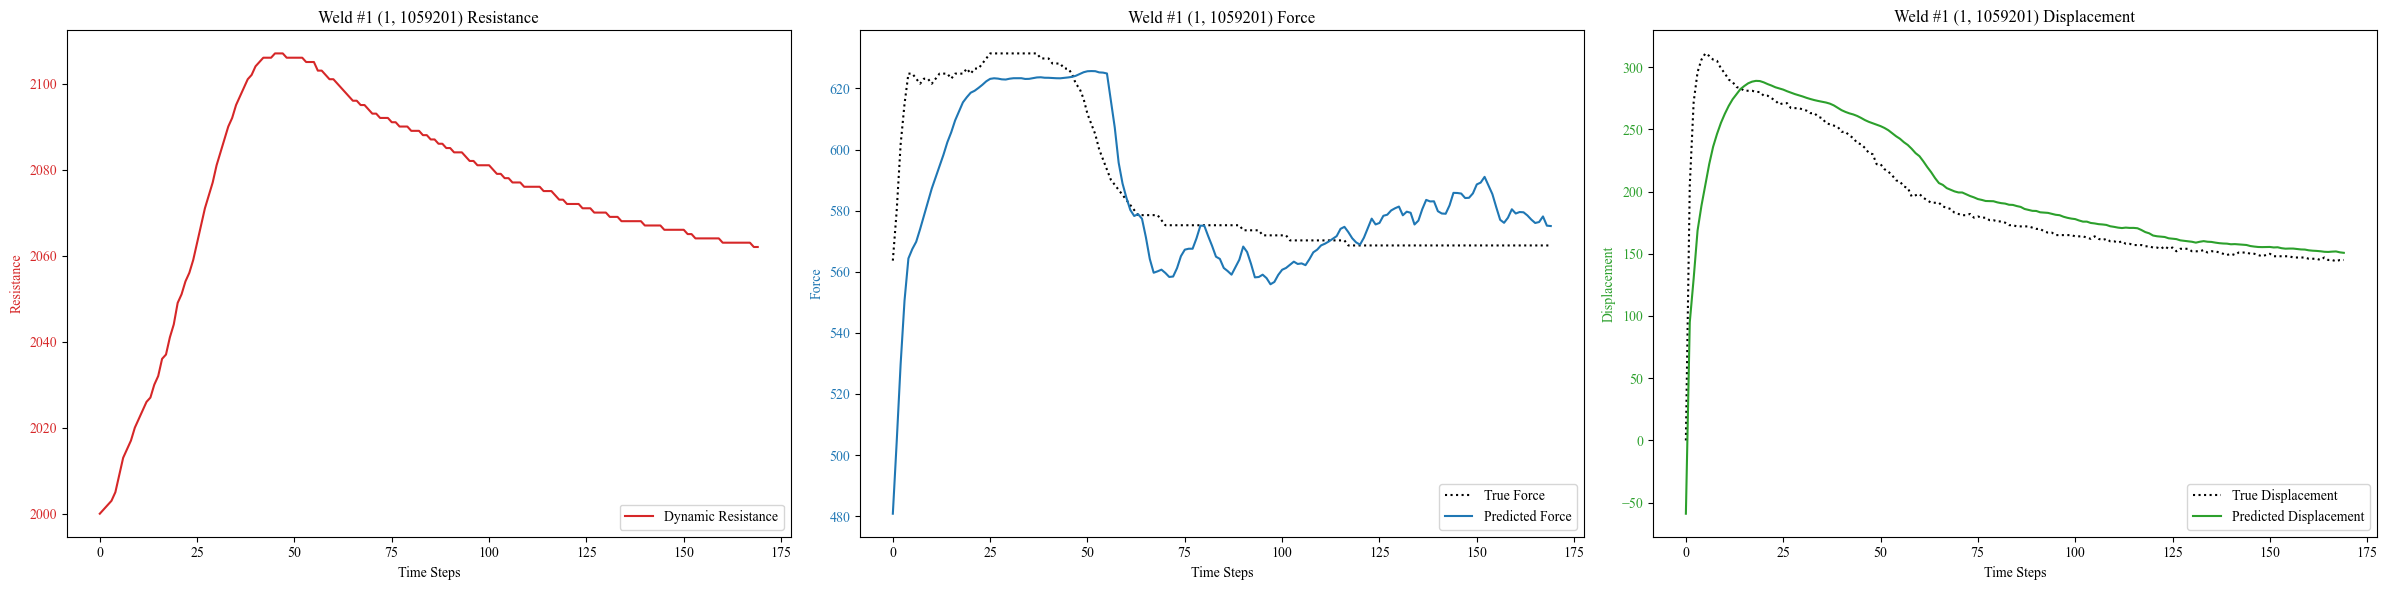

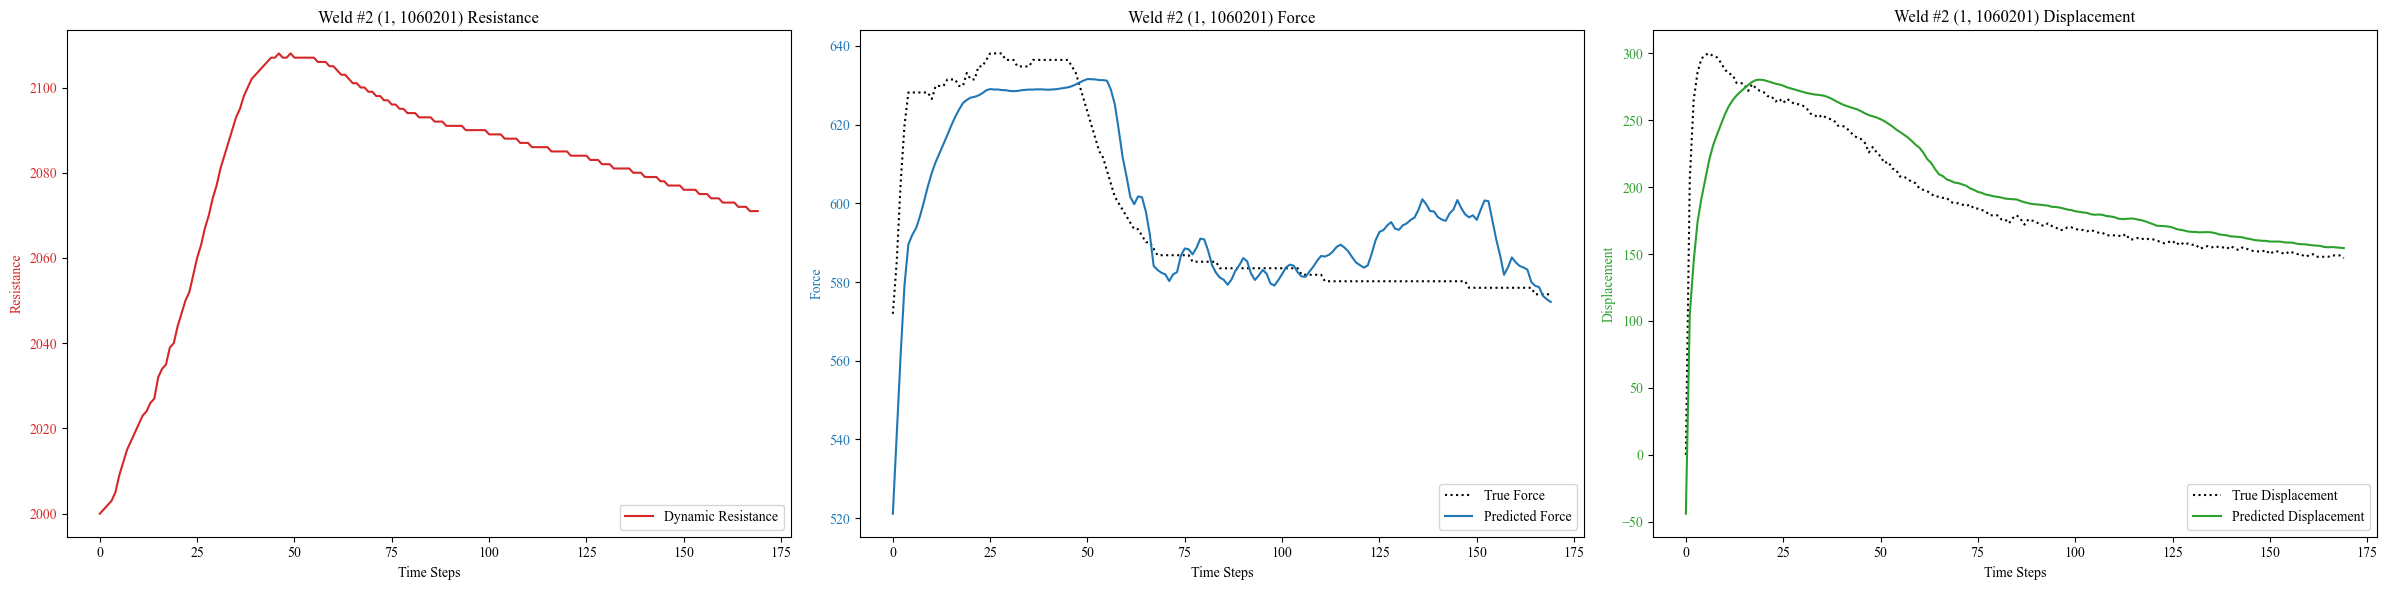

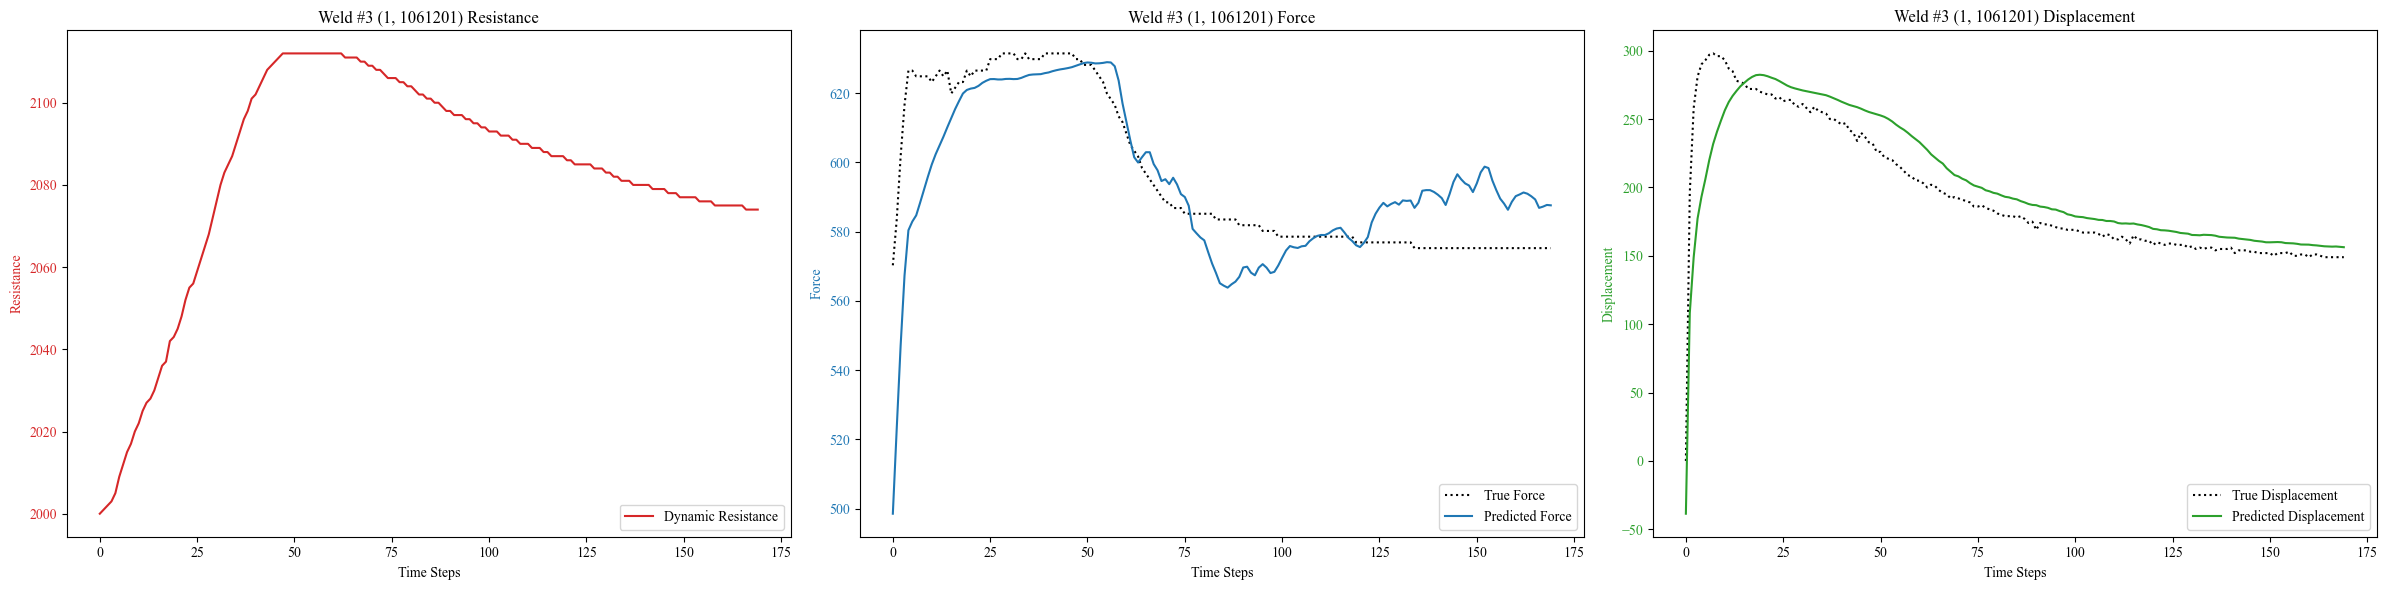

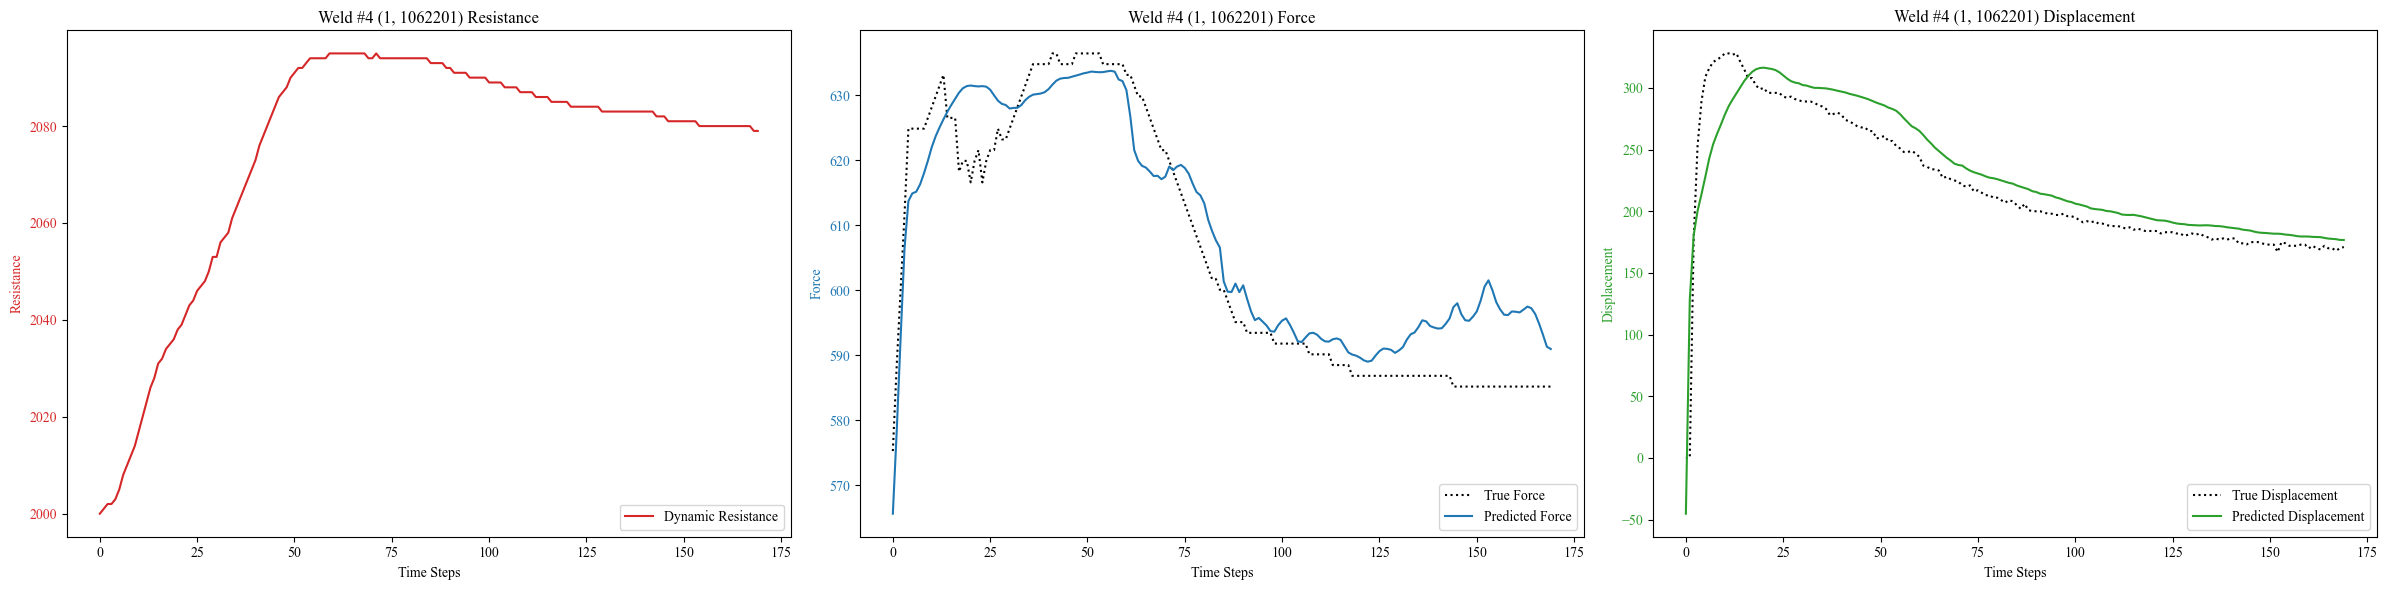

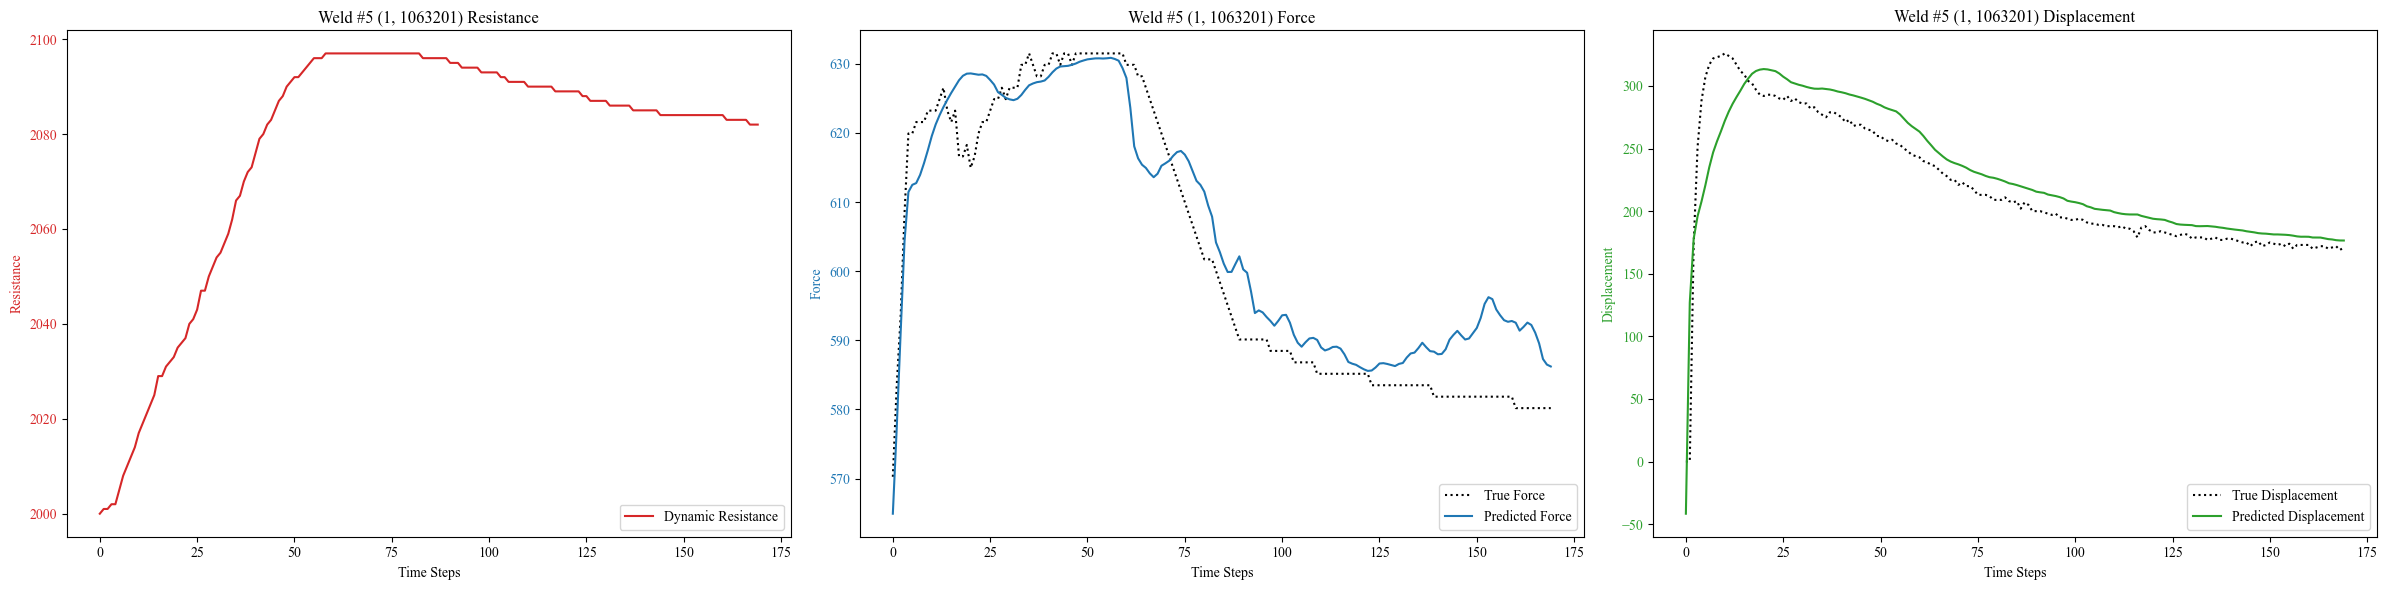

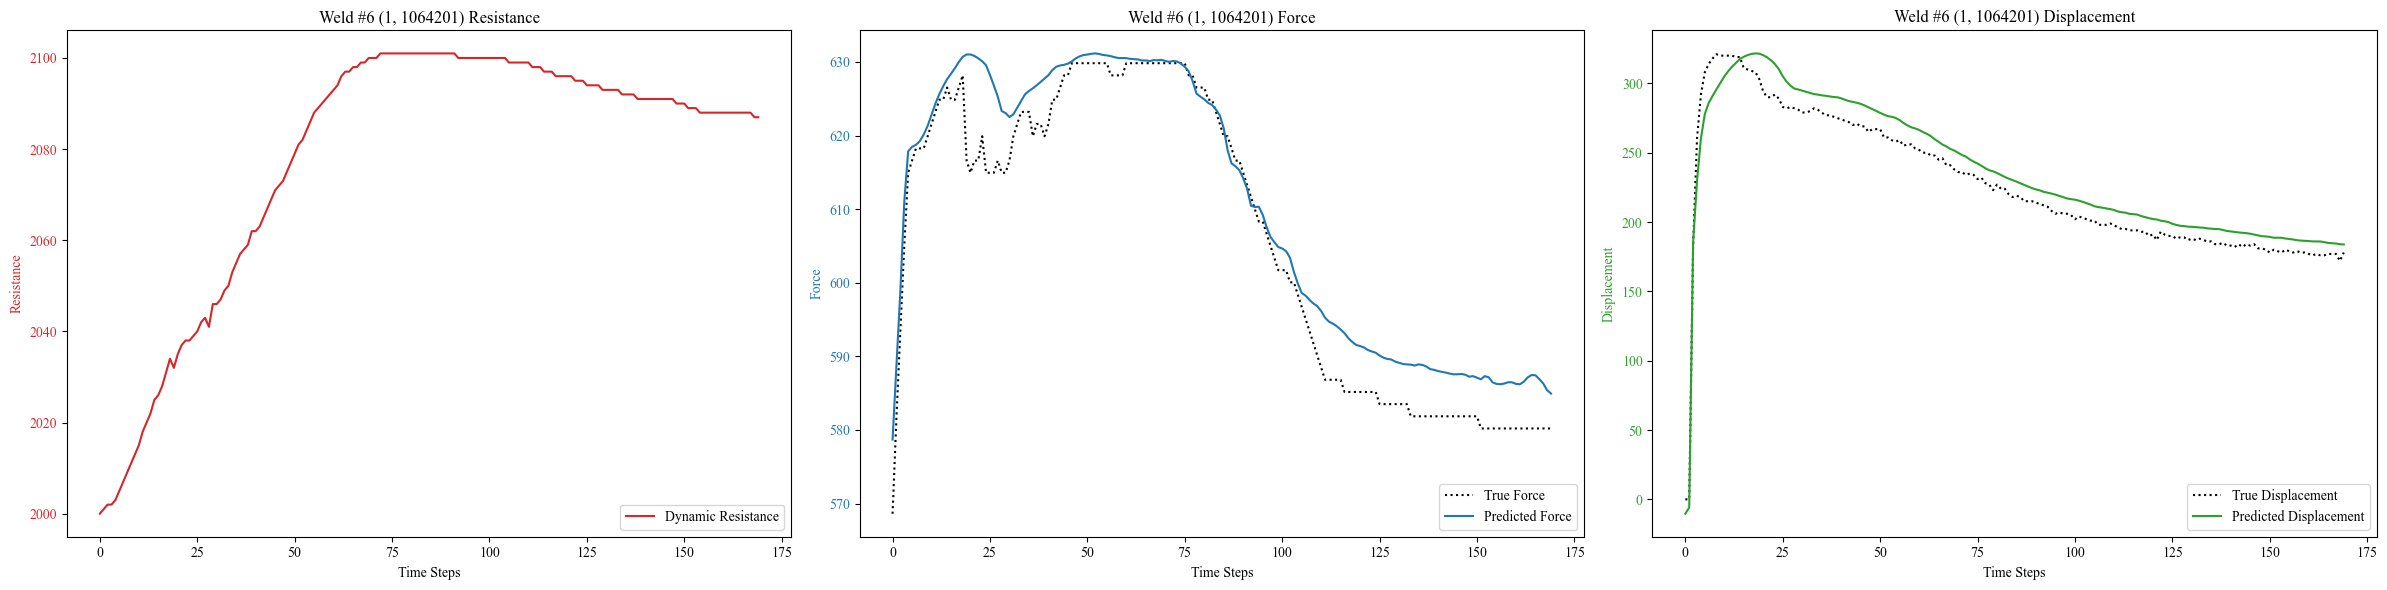

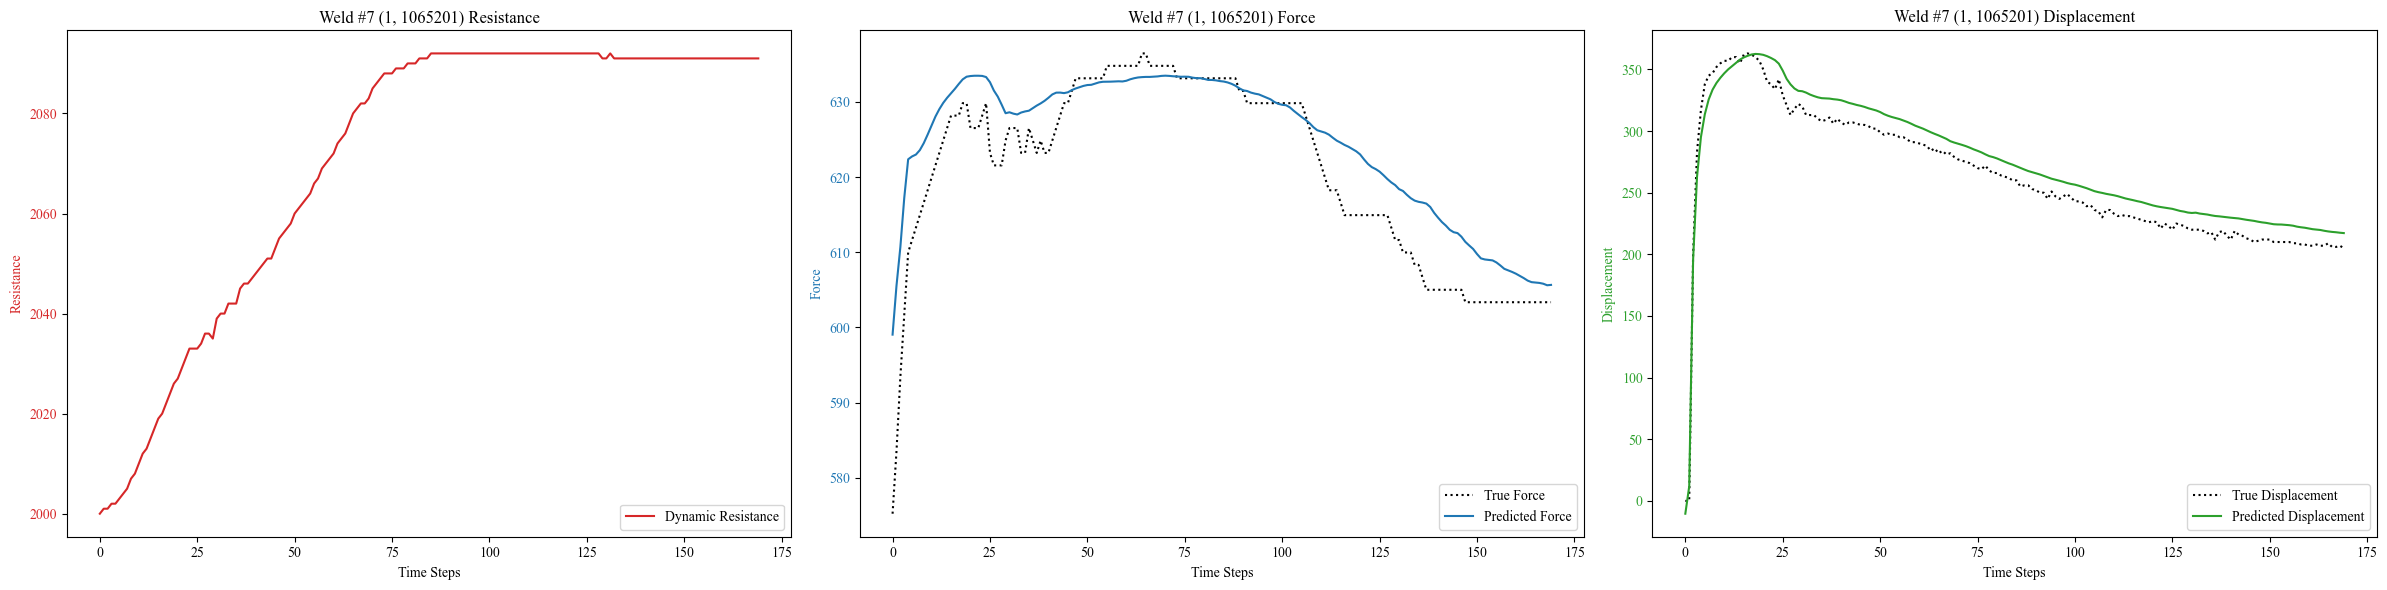

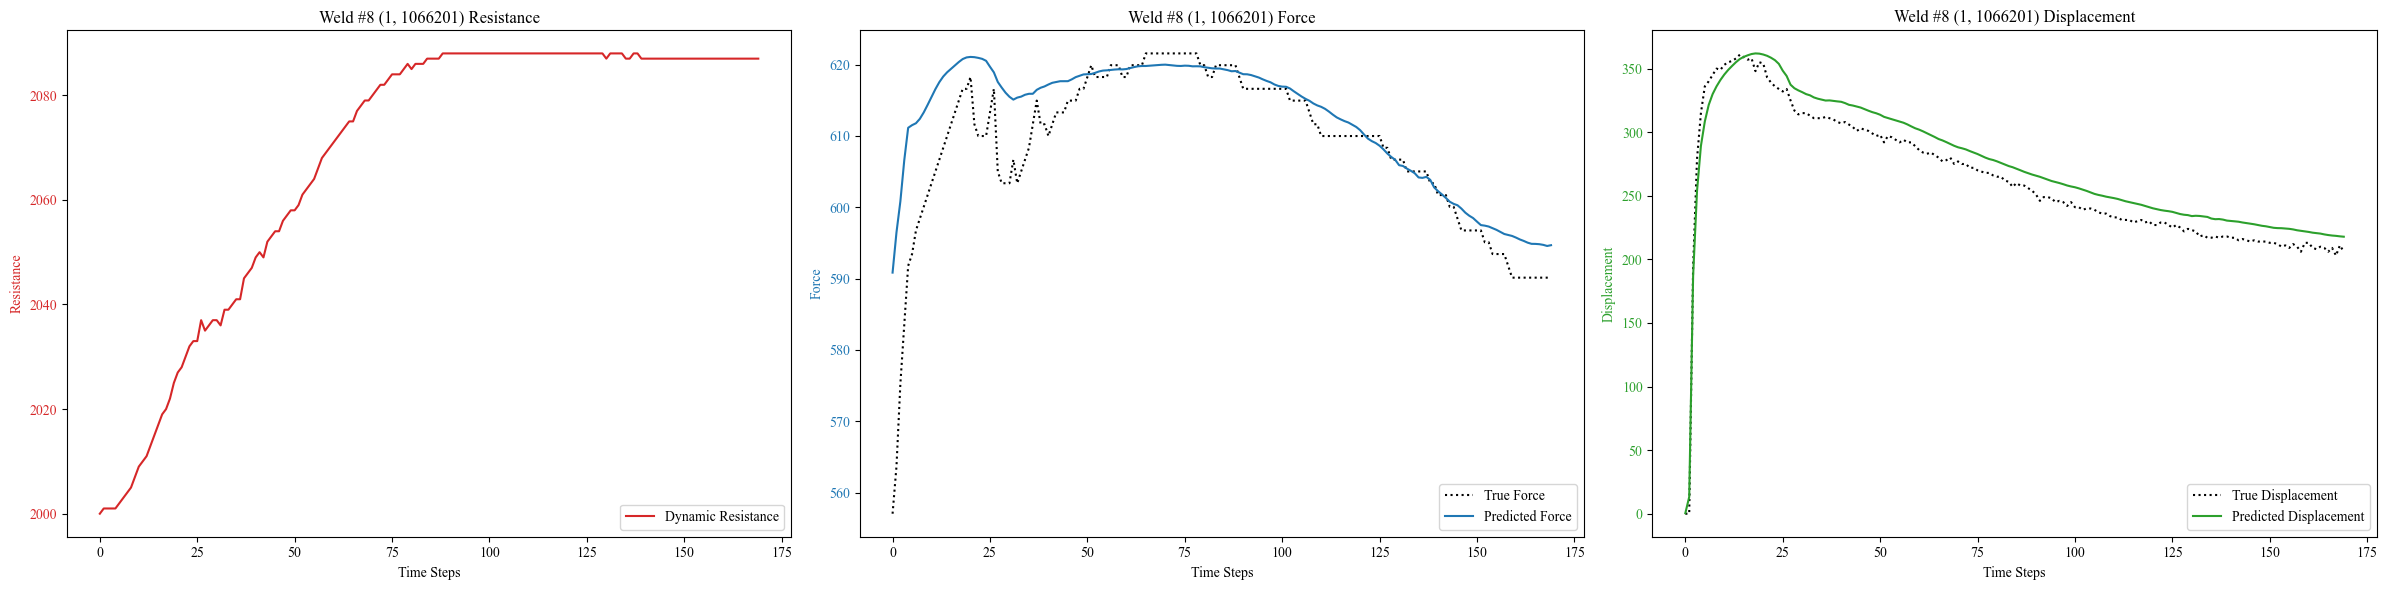

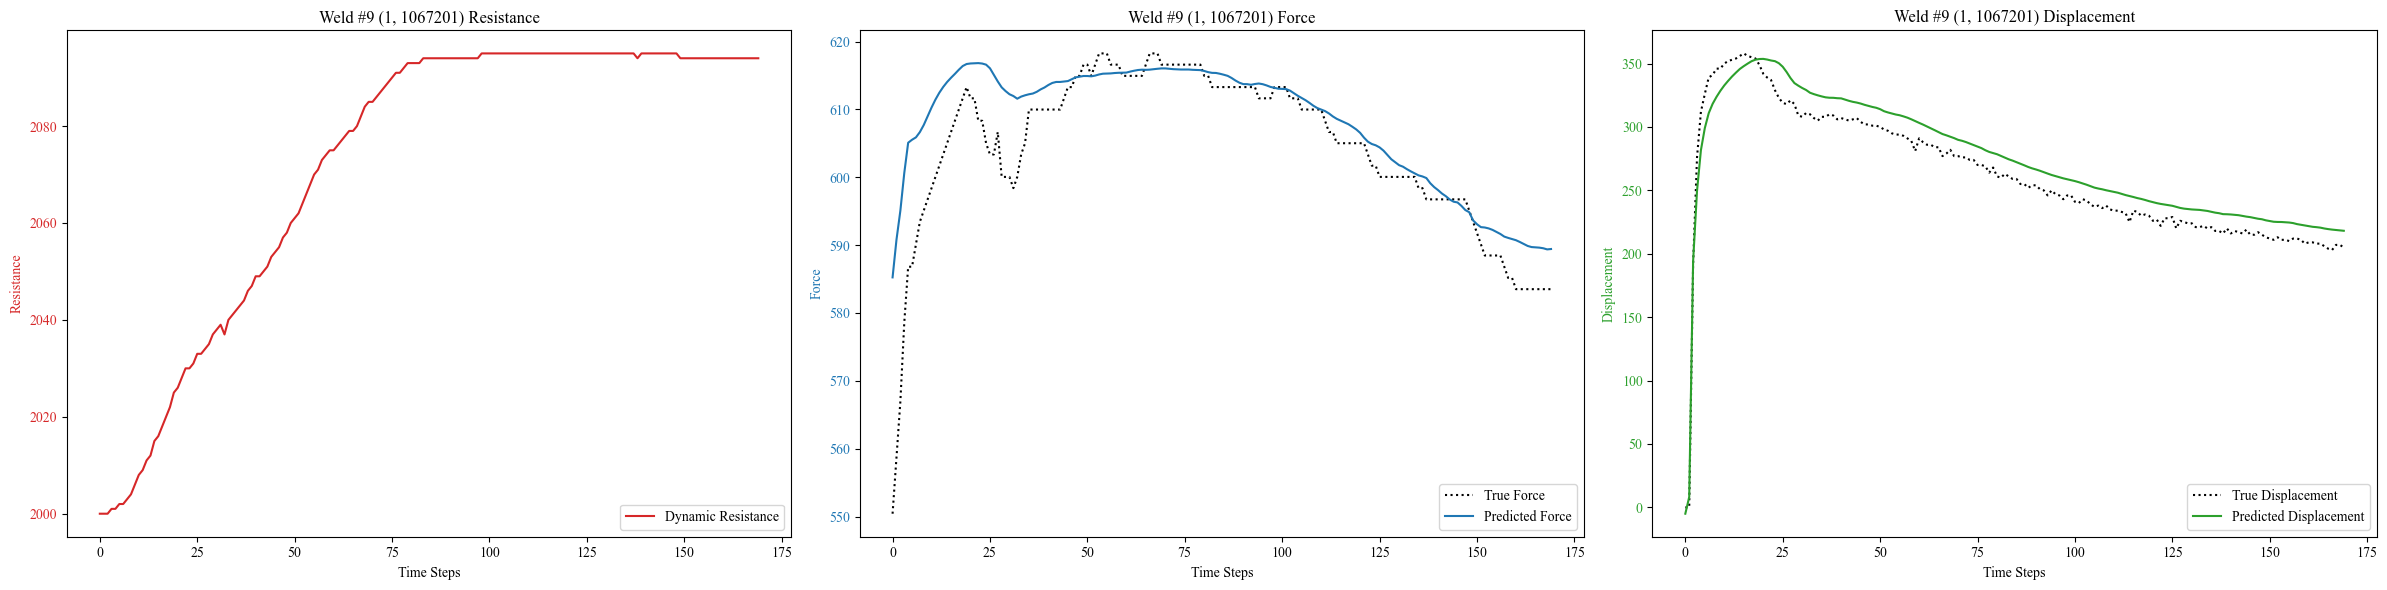

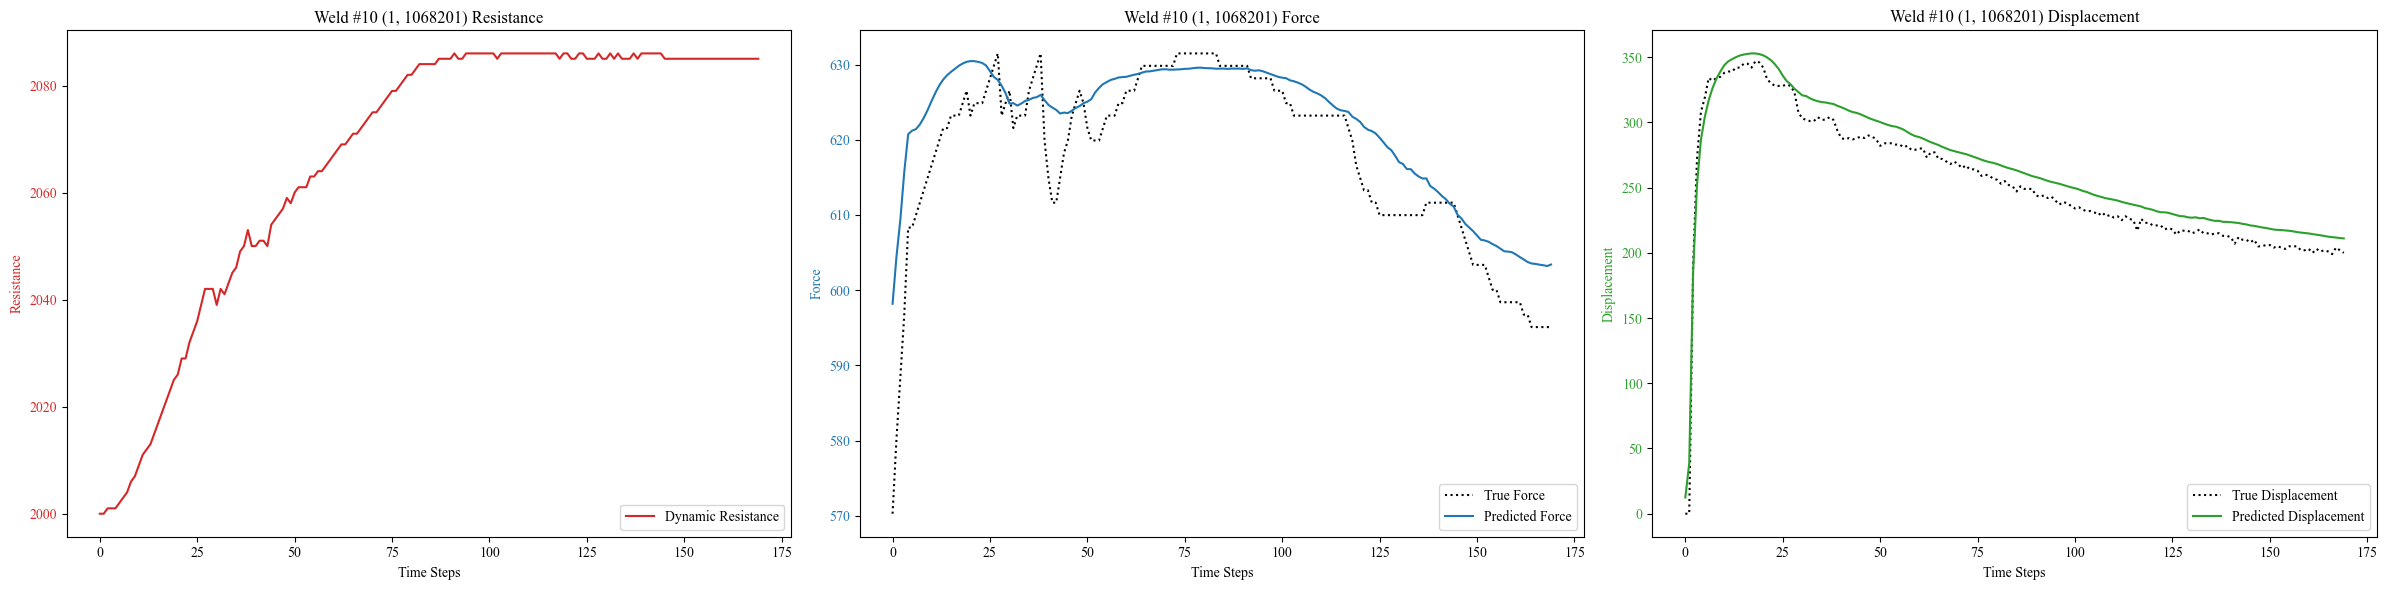

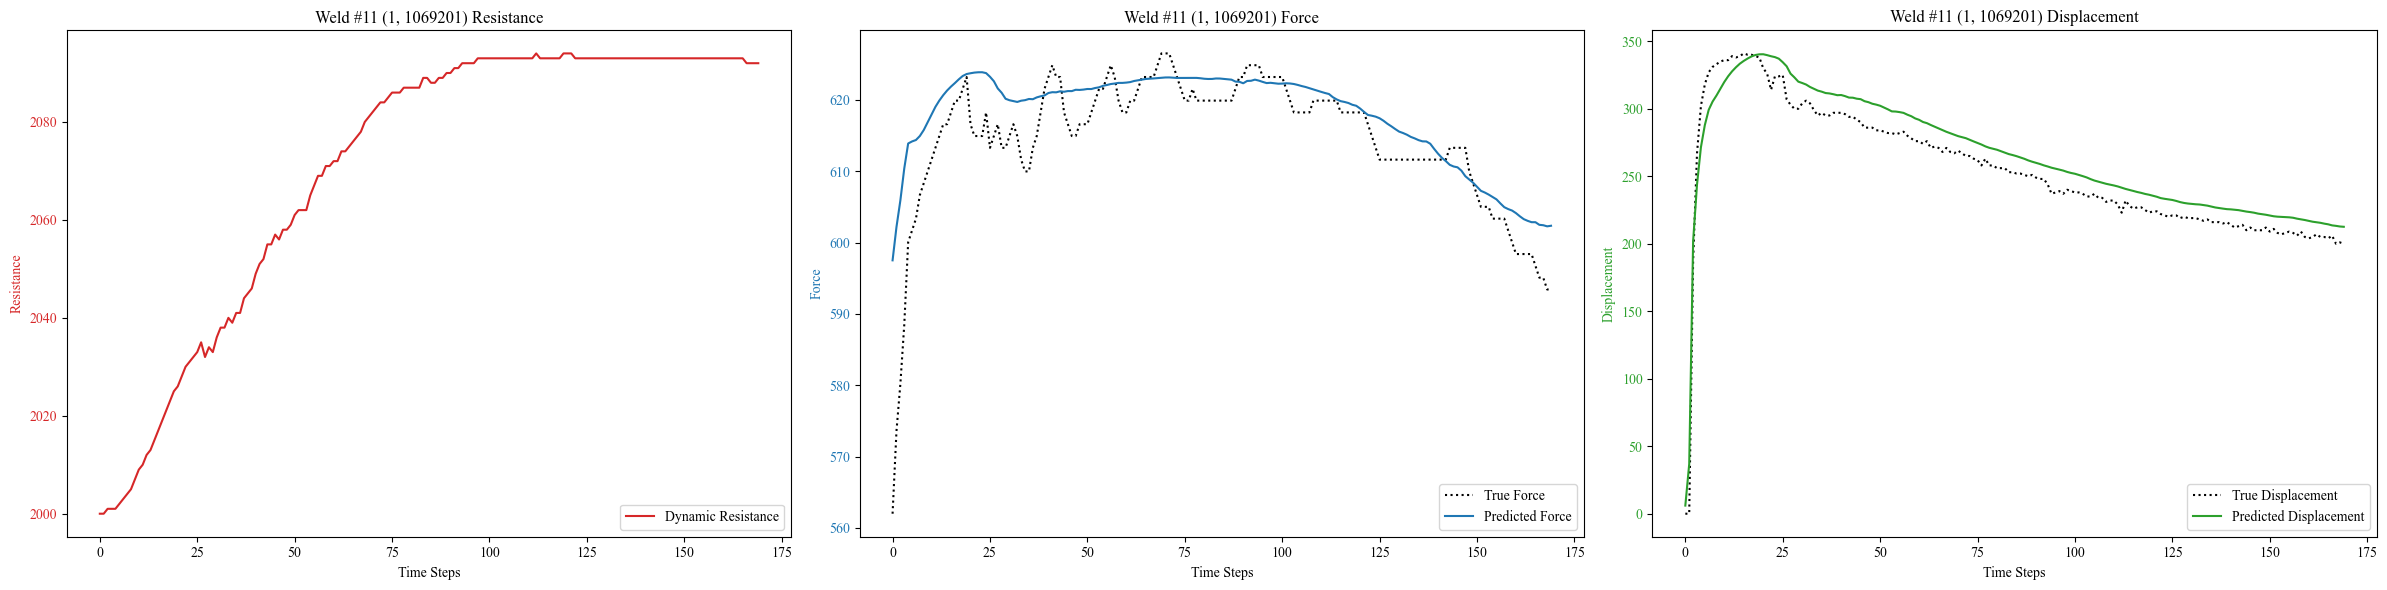

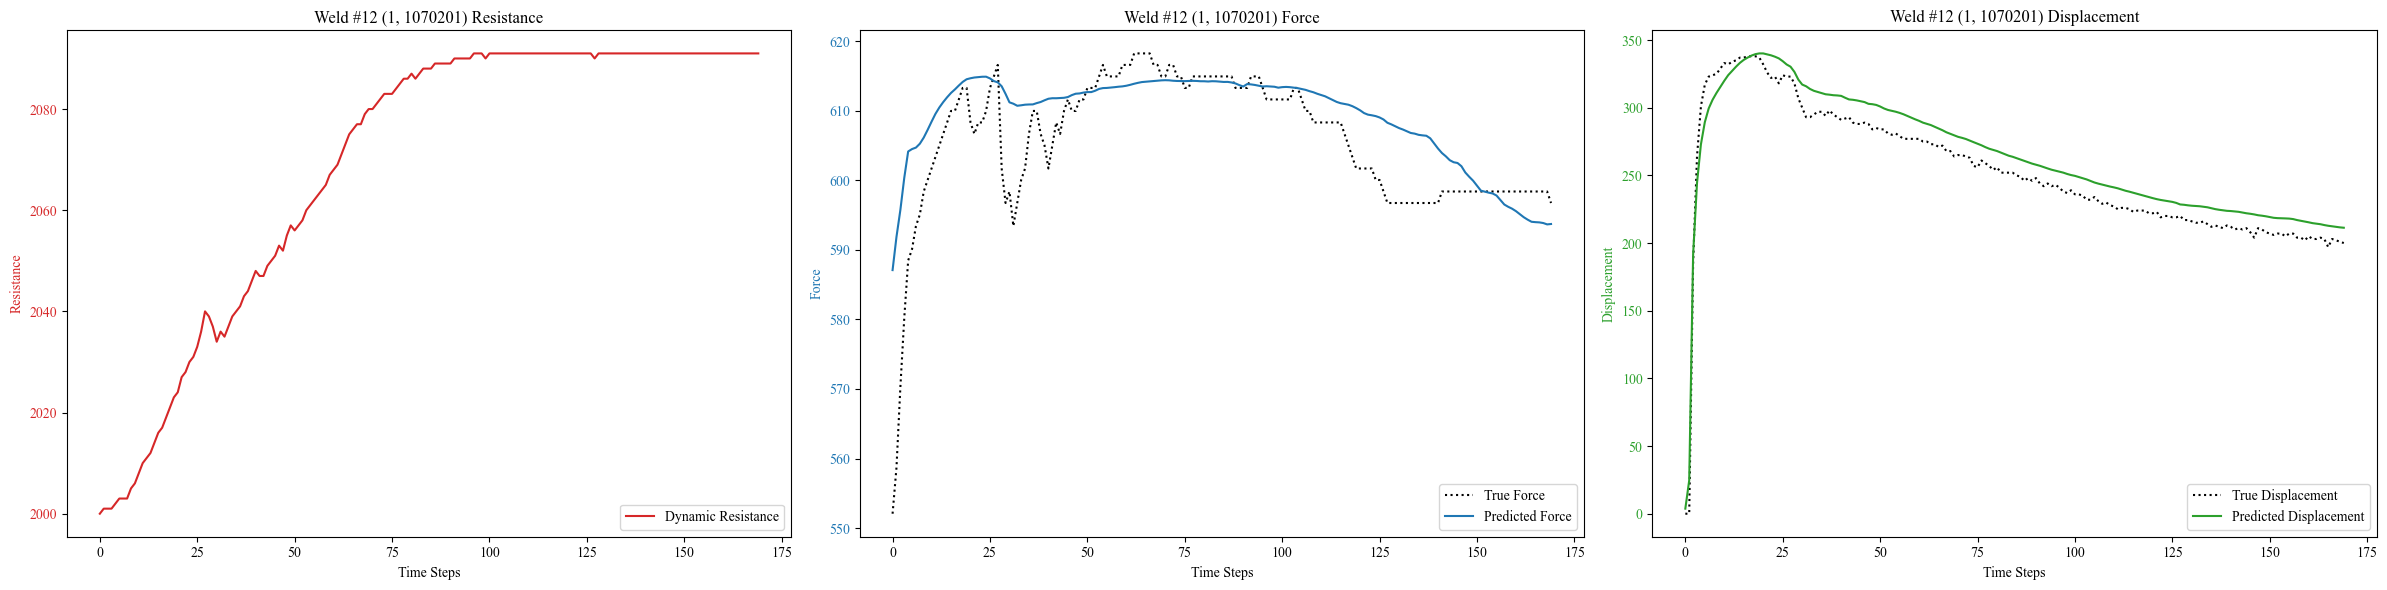

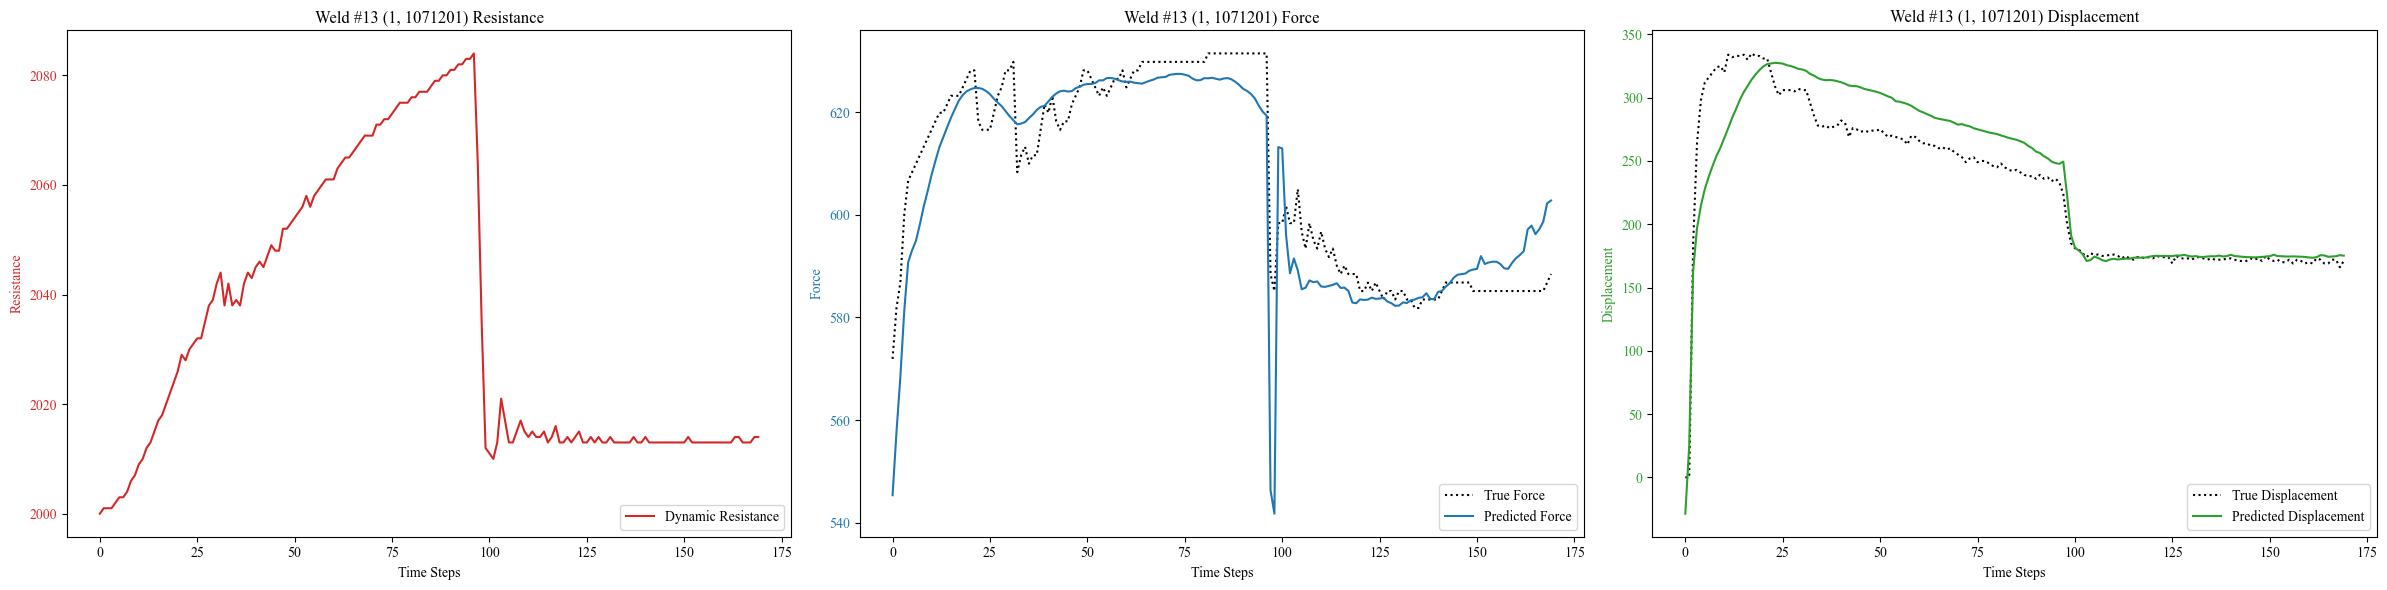

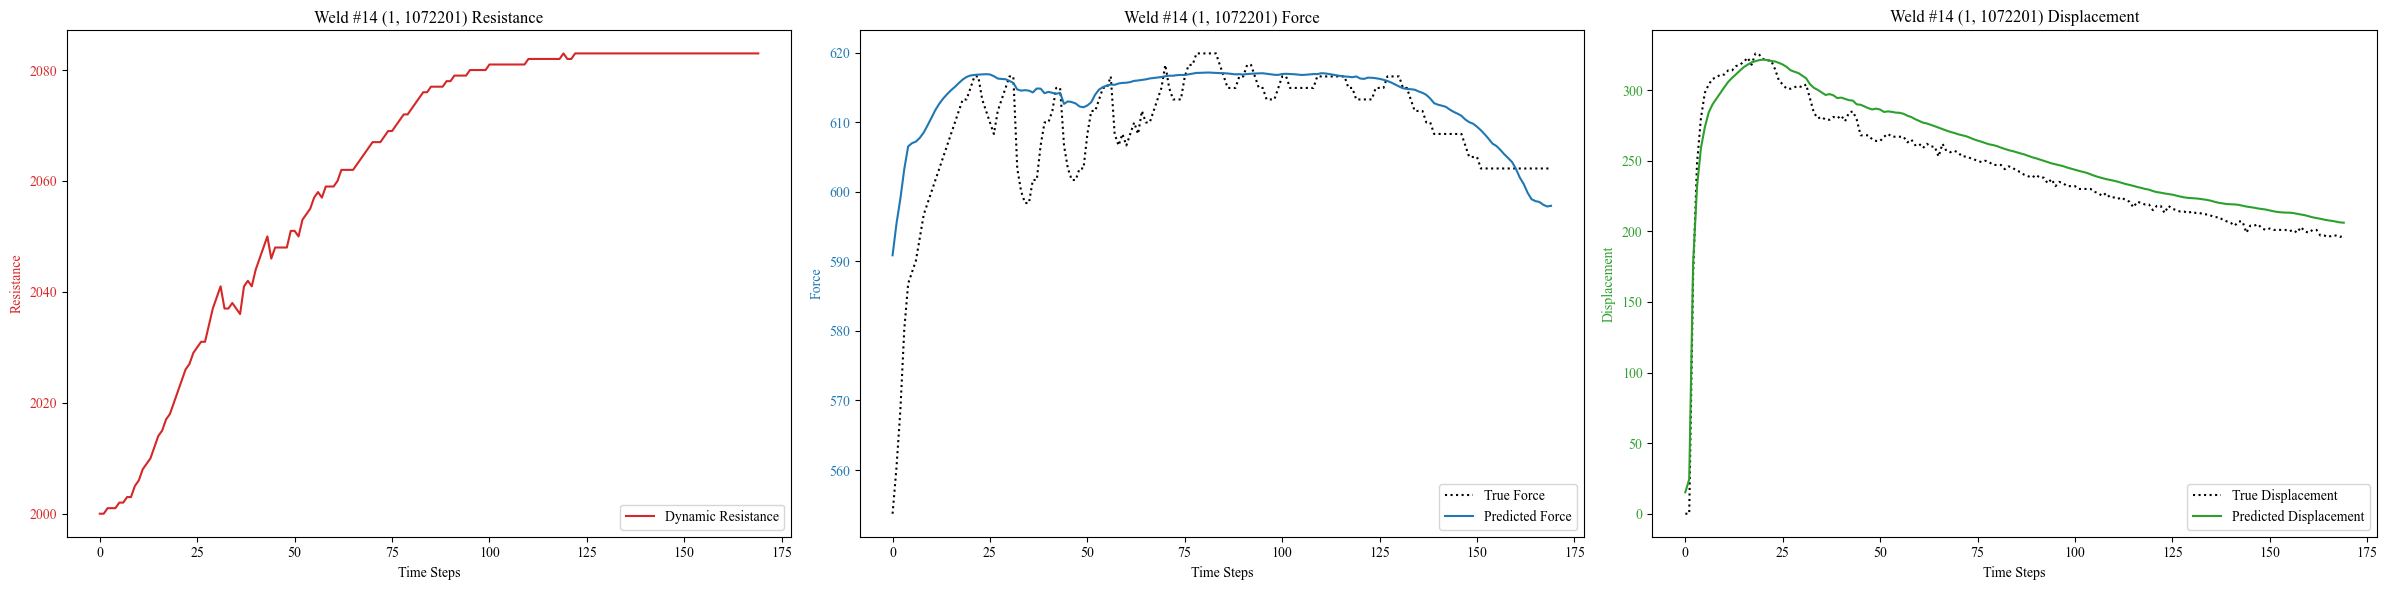

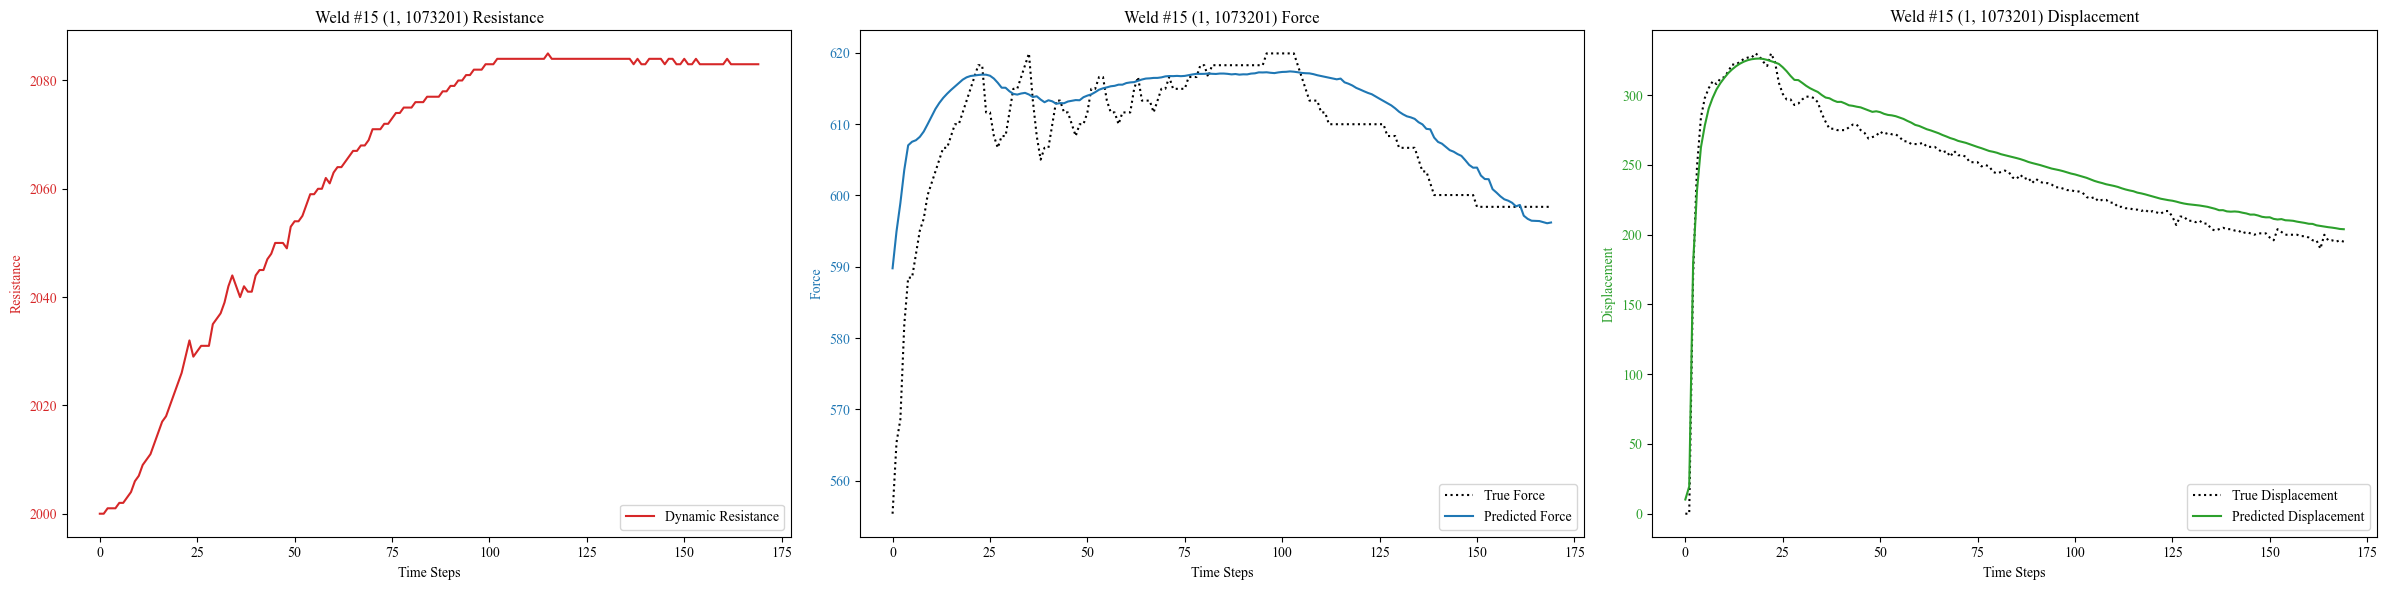

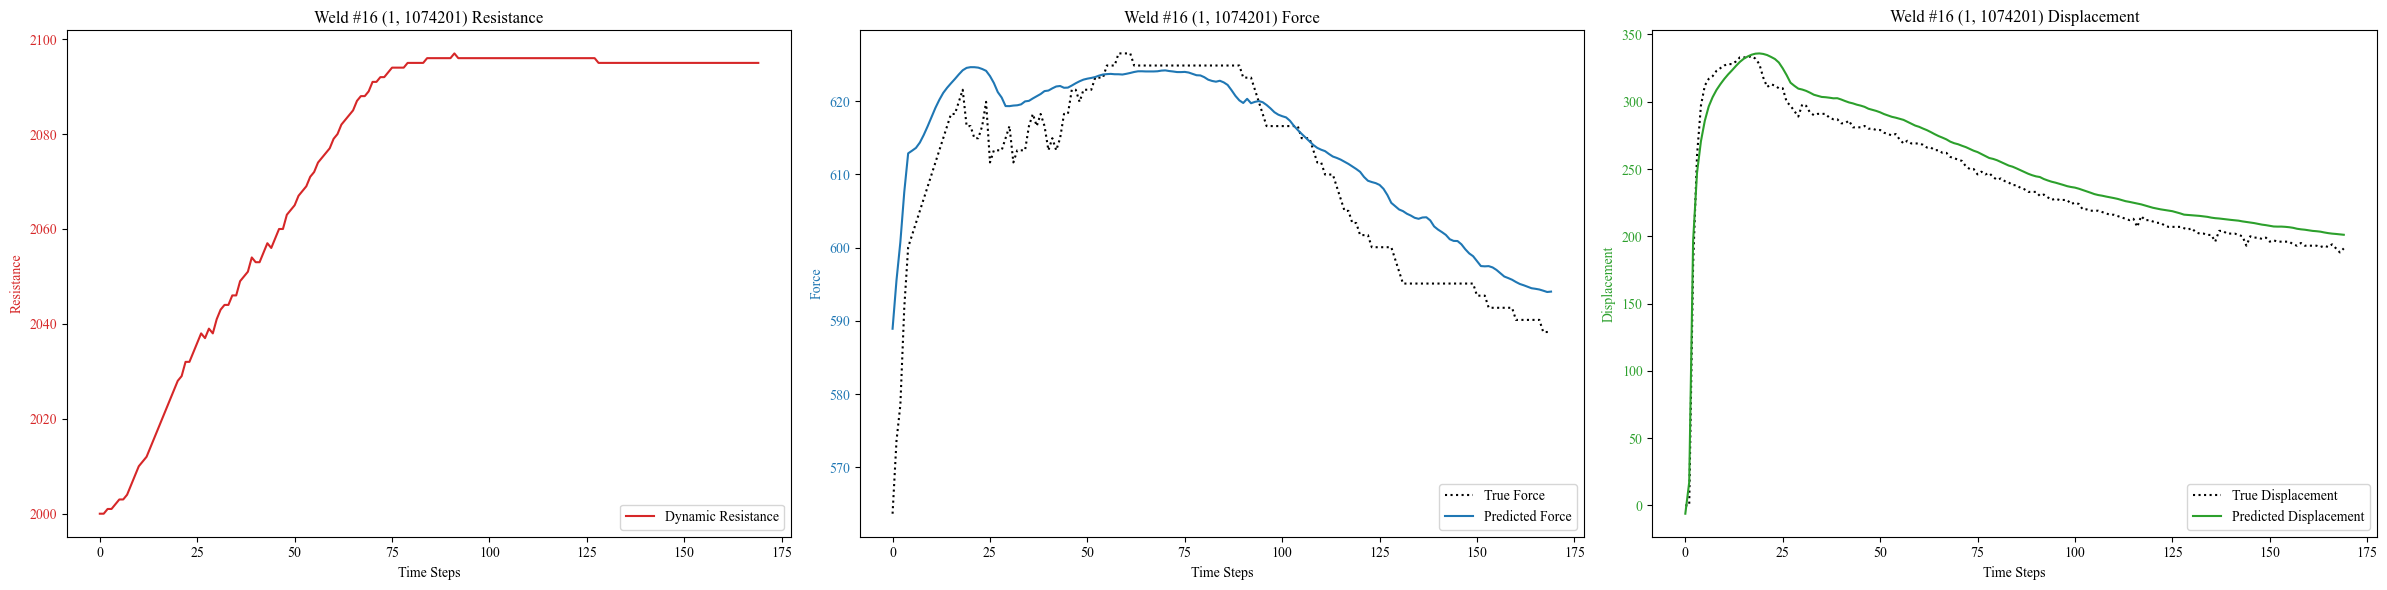

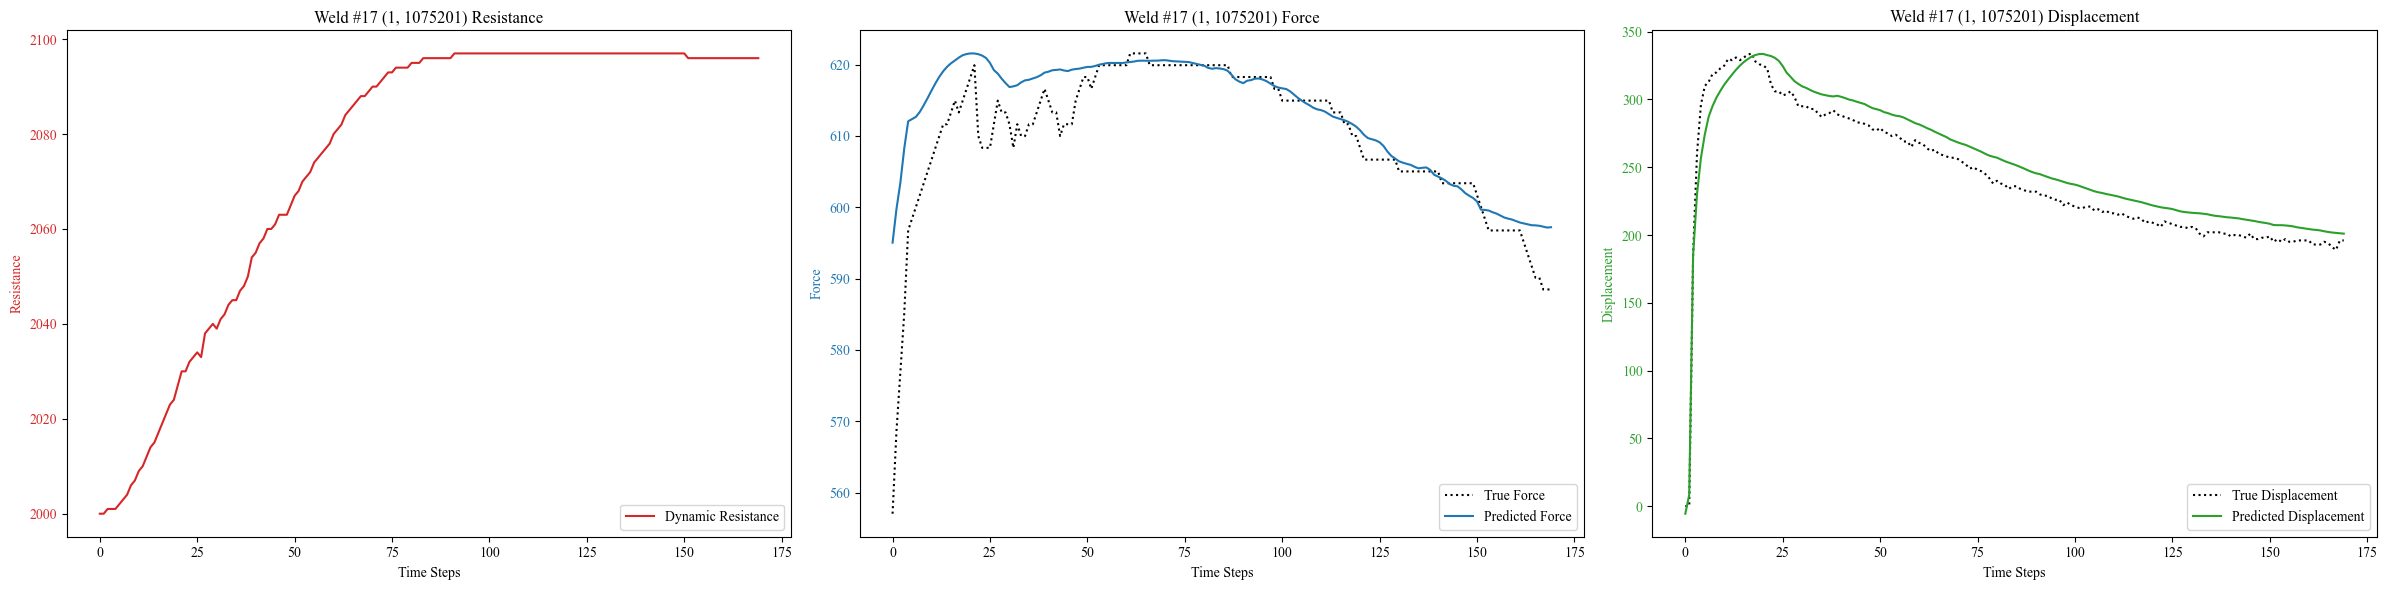

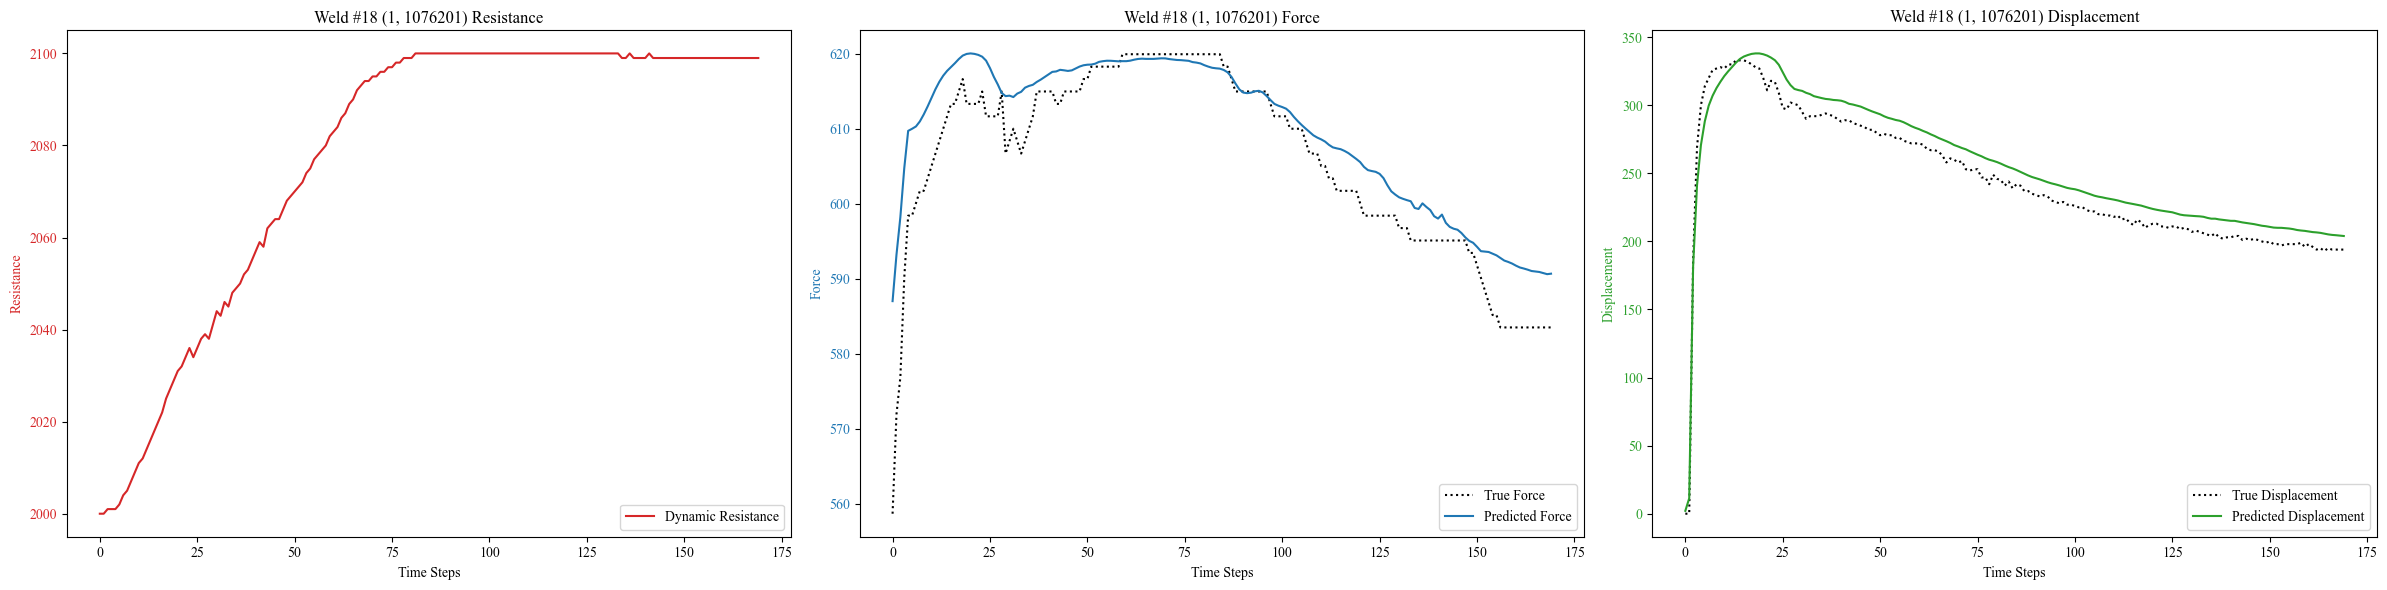

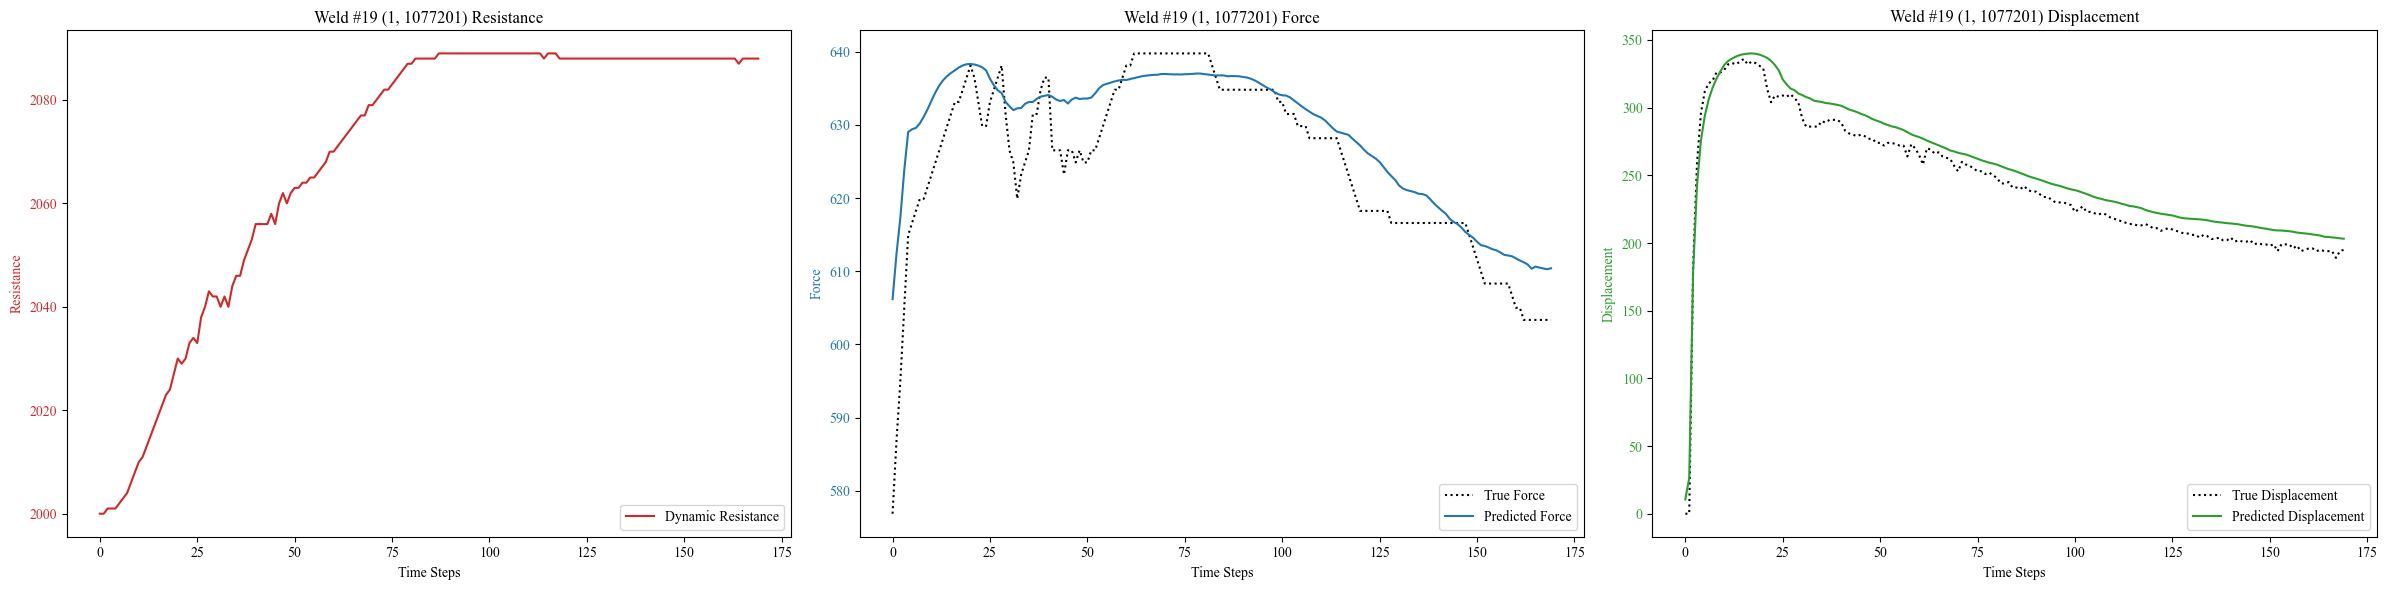

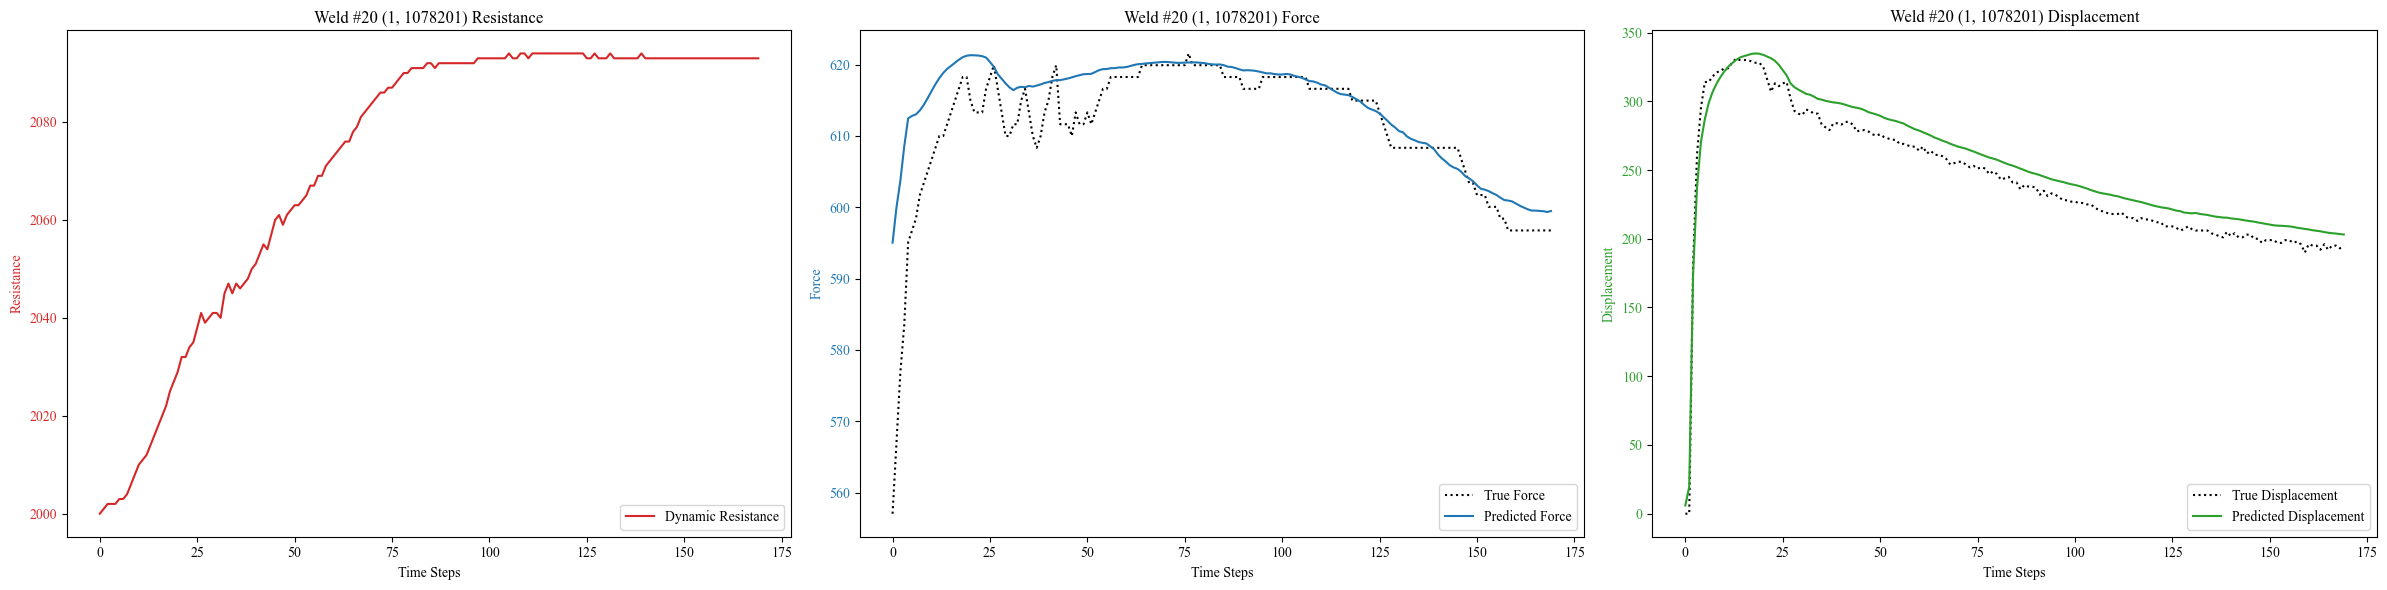

In [7]:
# Save test loss as the name of a .txt file
open(os.path.join(model_save_folder, f"LOSS_STANDARD_{average_loss:.5f}__RMSE_{average_rmse:.5f}__R2_{average_r2:.5f}.txt"), 'w')

# Plotting
plot_loss(loss_save_path, folder_path)
plot_function(results[0:20], folder_path)